In [ ]:
!pip3 install torch==1.2.0+cu92 torchvision==0.4.0+cu92 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [ ]:
!pip3 install torchinfo

In [1]:
import os
import torch
import torchvision
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
import torchvision.models as models
from torchinfo import summary
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torchvision.utils import save_image
import torchvision.transforms as tt
from torchvision.datasets.folder import default_loader
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image
import numpy as np
from PIL import ImageFile

%matplotlib inline

**GPU**

In [2]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

"""Move tensor(s) to chosen device"""
def to_device(data, device):
  if isinstance(data, (list,tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
  """Wrap a dataloader to move data to a device"""
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device
  
  def __iter__(self):
    for b in self.dl: 
      yield to_device(b, self.device)

  def __len__(self):
    """Number of batches"""
    return len(self.dl)

In [43]:
device = get_default_device()
device
torch.manual_seed(0)

**Dataset Lookthrough**

In [4]:
data_dir = '../jialin/dataset'
dataset = ImageFolder(data_dir)
len(dataset)
ImageFile.LOAD_TRUNCATED_IMAGES = True

(480, 480)


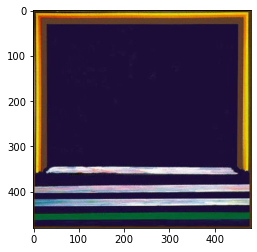

In [ ]:
img, label = dataset[2]
print(img.size)
plt.imshow(img)

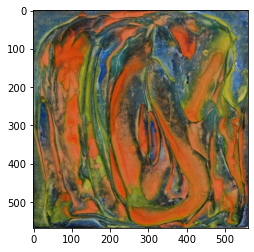

In [ ]:
img, label = dataset[750]
plt.imshow(img)

**Data preprocessing**
- resize to 64 x 64
- convert them to tensors and normalize them
- create dataloader
- look at sample

In [5]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [44]:
train_ds = ImageFolder(data_dir, transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=8, pin_memory=True) # [128, 3, 64, 64]

In [45]:
train_ds.class_to_idx

{'abstract': 0,
 'cityscape': 1,
 'figurative': 2,
 'flower-painting': 3,
 'genre-painting': 4,
 'landscape': 5,
 'marina': 6,
 'portrait': 7,
 'religious-painting': 8,
 'still-life': 9}

In [46]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
    n_row = np.sqrt(nmax)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=n_row).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images.cpu(), nmax)
        print(images.shape)
        break

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


TypeError: ignored

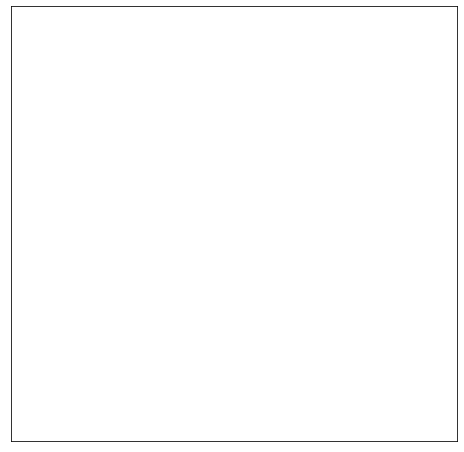

In [30]:
# random samples from dataset
show_batch(train_dl)

In [47]:
# move data to GPU
train_dl = DeviceDataLoader(train_dl, device)

**Discriminator Network**
- use a convolutional neural networks (CNN) which outputs a single number output for every image
- use stride of 2 to progressively reduce the size of the output feature map

In [48]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_blocks = nn.Sequential(
          # in: 3 x 64 x 64
          nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
          nn.BatchNorm2d(64),
          nn.LeakyReLU(0.2, inplace=True),
          # out: 64 x 32 x 32

          nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
          nn.BatchNorm2d(128),
          nn.LeakyReLU(0.2, inplace=True),
          # out: 128 x 16 x 16

          nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
          nn.BatchNorm2d(256),
          nn.LeakyReLU(0.2, inplace=True),
          # out: 256 x 8 x 8

          nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
          nn.BatchNorm2d(512),
          nn.LeakyReLU(0.2, inplace=True),
          # out: 512 x 4 x 4
        )
        self.flat = nn.Flatten()
        self.adv_layer = nn.Sequential(
            nn.Linear(512*4*4, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 1000),
            nn.ReLU(inplace=True),
            nn.Linear(1000, 1),
            nn.Sigmoid()
        )
        self.aux_layer = nn.Sequential(
            nn.Linear(512*4*4, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 1000),
            nn.ReLU(inplace=True),
            nn.Linear(1000, 10),
        )


    def forward(self, img):
        out = self.conv_blocks(img)
        flat = self.flat(out)
        
        validity = self.adv_layer(flat)
        label = self.aux_layer(flat)

        return validity, label

In [49]:
discriminator = Discriminator().to(device)

In [50]:
summary(discriminator, input_size=(128, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            --                        --
├─Sequential: 1-1                        [128, 512, 4, 4]          --
│    └─Conv2d: 2-1                       [128, 64, 32, 32]         3,072
│    └─BatchNorm2d: 2-2                  [128, 64, 32, 32]         128
│    └─LeakyReLU: 2-3                    [128, 64, 32, 32]         --
│    └─Conv2d: 2-4                       [128, 128, 16, 16]        131,072
│    └─BatchNorm2d: 2-5                  [128, 128, 16, 16]        256
│    └─LeakyReLU: 2-6                    [128, 128, 16, 16]        --
│    └─Conv2d: 2-7                       [128, 256, 8, 8]          524,288
│    └─BatchNorm2d: 2-8                  [128, 256, 8, 8]          512
│    └─LeakyReLU: 2-9                    [128, 256, 8, 8]          --
│    └─Conv2d: 2-10                      [128, 512, 4, 4]          2,097,152
│    └─BatchNorm2d: 2-11                 [128, 512, 4, 4]     

**Generator Network**
- input: a vector or a matrix of random numbers (referred to as a latent tensor) which is used as a seed for generating an image
- convert a latent tensor of shape (128, 1, 1) into an image tensor of shape 3 x 28 x 28 using the ConvTranspose2d layer from PyTorch, which is performs to as a transposed convolution (also referred to as a deconvolution)

In [51]:
latent_size = 128

In [52]:
from torch.nn.modules.conv import ConvTranspose2d
from torch.nn.modules.activation import ReLU
from torch.nn.modules.batchnorm import BatchNorm2d
class Generator(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv_block = nn.Sequential(
        nn.ConvTranspose2d(latent_size + 10, 512, kernel_size=4, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2, inplace=True),

        nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2, inplace=True),

        nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2, inplace=True),

        nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2, inplace=True),

        nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
        nn.Tanh(),
    )

  def forward(self, input):
    img = self.conv_block(input)

    return img

In [53]:
generator = Generator().to(device)
summary(generator, input_size=[(128, 138, 1, 1)])

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                --                        --
├─Sequential: 1-1                        [128, 3, 64, 64]          --
│    └─ConvTranspose2d: 2-1              [128, 512, 4, 4]          1,130,496
│    └─BatchNorm2d: 2-2                  [128, 512, 4, 4]          1,024
│    └─LeakyReLU: 2-3                    [128, 512, 4, 4]          --
│    └─ConvTranspose2d: 2-4              [128, 256, 8, 8]          2,097,152
│    └─BatchNorm2d: 2-5                  [128, 256, 8, 8]          512
│    └─LeakyReLU: 2-6                    [128, 256, 8, 8]          --
│    └─ConvTranspose2d: 2-7              [128, 128, 16, 16]        524,288
│    └─BatchNorm2d: 2-8                  [128, 128, 16, 16]        256
│    └─LeakyReLU: 2-9                    [128, 128, 16, 16]        --
│    └─ConvTranspose2d: 2-10             [128, 64, 32, 32]         131,072
│    └─BatchNorm2d: 2-11                 [128, 64, 32, 3

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1).to(device)
label = torch.randint(10, (128,1)).to(device)
fake_images = generator(xb, label)
print(fake_images.shape)
show_images(fake_images.cpu())

TypeError: ignored

**Discriminator Training**
- use the binary cross entropy loss function
- input 1 as real and 0 as fake image from generator
- first pass a batch of real images, and compute the loss, setting the target labels to 1
- then pass a batch of fake images (generated using the generator) pass them into the discriminator, and compute the loss, setting the target labels to 0
- add the two losses and use the overall loss to perform gradient descent to adjust the weights of the discriminator

In [ ]:
def train_discriminator(opt_d, real_images, real_label):
  # Clear discriminator gradients
  opt_d.zero_grad()

  # Pass real images through discriminator
  real_pred, real_aux = discriminator(real_images)
  real_targets = torch.ones(real_images.size(0), 1).to(device)
  real_loss = F.binary_cross_entropy(real_pred, real_targets)
  real_aux_loss = F.cross_entropy(real_aux, real_label)
  
  real_score = torch.mean(real_pred).item()
  real_aux_score = torch.mean(real_aux_loss).item()
    
  # Generate fake images
  fake_label = torch.randint(10, (batch_size,1)).to(device)
  latent = torch.randn(batch_size, 1, latent_size).to(device)
  fake_images = generator(latent, fake_label)

  # Pass fake images through discriminator
  fake_targets = torch.zeros(fake_images.size(0), 1).to(device)
  fake_pred, _ = discriminator(fake_images)
  fake_loss = F.binary_cross_entropy(fake_pred, fake_targets)
  fake_score = torch.mean(fake_pred).item()

  # Update discriminator weights
  loss = real_loss + real_aux_loss + fake_loss
  loss.backward()
  opt_d.step()
  return loss.item(), real_score, fake_score, real_aux_score

**Generator Training**
- generate a batch of images using the generator, pass it into the discriminator
- calculate the loss by setting the target labels to 1
- use the loss to perform gradient descent

In [ ]:
def train_generator(opt_g):
  # Clear generator gradients
  opt_g.zero_grad()
    
  # Generate fake images
  latent = torch.randn(batch_size, 1, latent_size).to(device)
  label = torch.randint(10, (batch_size,1)).to(device)
  fake_images = generator(latent, label)
    
  # Try to fool the discriminator
  pred, aux = discriminator(fake_images)

  targets = torch.ones(batch_size, 1).to(device)
  img_loss = F.binary_cross_entropy(pred, targets)
  aux_loss = F.cross_entropy(aux, torch.squeeze(label))
  fake_score = torch.mean(pred).item()

  # Update generator weights
  loss = img_loss + aux_loss
  loss.backward()
  opt_g.step()
    
  return loss.item(), fake_score

**Generated Images**

In [54]:
date = '0329'
img_dir = date + '_plot'

In [55]:
def save_samples(index, show=True):
  latent = torch.randn(100, latent_size, 1, 1).to(device)
  label = np.zeros((100,))
  for i in range(10):
    for j in range(10):
      label[10*i+j]=i
  label = torch.tensor(label, dtype=torch.int64).to(device)
  label = F.one_hot(label, 10).unsqueeze(-1).unsqueeze(-1)
  g_input = torch.cat((latent, label), dim=1)
  fake_images = generator(g_input)
  fake_fname = 'generated-images-{0:0=4d}.png'.format(index)

  save_image(denorm(fake_images), os.path.join(img_dir, fake_fname), nrow=10)
  print('Saving', fake_fname)
  if show:
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(fake_images).cpu().detach(), nrow=10).permute(1, 2, 0))

In [56]:
def save_model(index):
  g_name = f"g_model_{index}"
  d_name = f"d_model_{index}"

  g_path = os.path.join(img_dir, g_name)
  d_path = os.path.join(img_dir, d_name)

  torch.save(generator.state_dict(), g_path)
  torch.save(discriminator.state_dict(), d_path)
  return

save_model(0)

Saving generated-images-0000.png


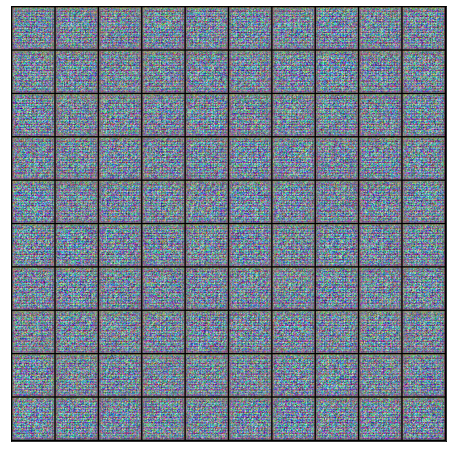

In [57]:
save_samples(0)

**Training the full loop**

In [36]:
lr = 0.0002
epochs = 300

In [58]:
def fit(start_epoch, epochs, lr, start_idx=1):
  torch.cuda.empty_cache()
  discriminator.to(device)
  generator.to(device)
    
  # optimizers
  opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
  opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
  for epoch in range(start_epoch, epochs):
    generator.train()
    discriminator.train()
    for real_images, real_label in tqdm(train_dl):
      # real_images = [batch, 3, 64, 64]
      # target
      real_targets = torch.ones(real_images.size(0), 1).to(device)
      fake_targets = torch.zeros(real_images.size(0), 1).to(device)

      # generate fake image
      latent_noise = torch.randn(real_images.size(0), latent_size, 1, 1).to(device)
      fake_label = torch.randint(10, (real_images.size(0),)).to(device)
      fake_label_onehot = F.one_hot(fake_label, 10).unsqueeze(-1).unsqueeze(-1).to(device)

      G_net_input = torch.cat((latent_noise, fake_label_onehot), dim=1)
      fake_images = generator(G_net_input)

      # ------------------------
      # Update Discriminator
      # ------------------------
      opt_d.zero_grad()

      real_pred, real_aux = discriminator(real_images)
      pred_errD_r = F.binary_cross_entropy(real_pred, real_targets)
      aux_errD_r = F.cross_entropy(real_aux, real_label)
      real_errD = pred_errD_r + aux_errD_r

      fake_pred, fake_aux = discriminator(fake_images.detach())
      pred_errD_f = F.binary_cross_entropy(fake_pred, fake_targets)
      aux_errD_f = F.cross_entropy(fake_aux, fake_label)
      fake_errD = pred_errD_f + aux_errD_f

      D_loss = real_errD + fake_errD
      D_loss.backward()
      opt_d.step()

      real_score = torch.mean(real_pred).item()
      fake_score1 = torch.mean(fake_pred).item()

      # ------------------------
      # Update Generator
      # ------------------------
      opt_g.zero_grad()

      fake_pred, fake_aux = discriminator(fake_images)
      pred_errG = F.binary_cross_entropy(fake_pred, real_targets)
      aux_errG = F.cross_entropy(fake_aux, fake_label)

      G_loss = pred_errG + aux_errG
      G_loss.backward()
      opt_g.step()

      fake_score2 = torch.mean(fake_pred).item()

    losses_g.append(G_loss.item())
    losses_d.append(D_loss.item())
    real_scores.append(real_score)
    fake_scores.append(fake_score1)
        
    print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score1: {:.4f}, fake_score2: {:.4f}".format(
          epoch+1, epochs, G_loss.item(), D_loss.item(), real_score, fake_score1, fake_score2))
    # evaluation
    with torch.no_grad():
      generator.eval()
      discriminator.eval()
      save_samples(epoch+start_idx, show=False)
    if (epoch+1) % 25 == 0:
      save_model(epoch+1)
    
  return losses_g, losses_d, real_scores, fake_scores

In [37]:
generator.load_state_dict(torch.load(f"{img_dir}/g_model_150"))
discriminator.load_state_dict(torch.load(f"{img_dir}/d_model_150"))

<All keys matched successfully>

In [59]:
losses_g = []
losses_d = []
real_scores = []
fake_scores = []

history = fit(0, epochs, lr)

  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [1/300], loss_g: 3.2164, loss_d: 3.8597, real_score: 0.7880, fake_score1: 0.2534, fake_score2: 0.1643
Saving generated-images-0001.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [2/300], loss_g: 1.9427, loss_d: 2.4531, real_score: 0.8491, fake_score1: 0.2314, fake_score2: 0.1657
Saving generated-images-0002.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [3/300], loss_g: 2.4695, loss_d: 2.5823, real_score: 0.6951, fake_score1: 0.0851, fake_score2: 0.1119
Saving generated-images-0003.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [4/300], loss_g: 1.2197, loss_d: 2.5824, real_score: 0.8044, fake_score1: 0.3722, fake_score2: 0.3118
Saving generated-images-0004.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [5/300], loss_g: 3.5976, loss_d: 2.2495, real_score: 0.9051, fake_score1: 0.1922, fake_score2: 0.0319
Saving generated-images-0005.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [6/300], loss_g: 3.2835, loss_d: 1.9466, real_score: 0.9854, fake_score1: 0.1100, fake_score2: 0.0454
Saving generated-images-0006.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [7/300], loss_g: 3.9111, loss_d: 1.9531, real_score: 0.9415, fake_score1: 0.1880, fake_score2: 0.0249
Saving generated-images-0007.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [8/300], loss_g: 3.6544, loss_d: 1.8740, real_score: 0.8424, fake_score1: 0.0303, fake_score2: 0.0343
Saving generated-images-0008.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [9/300], loss_g: 3.1838, loss_d: 4.6512, real_score: 0.1611, fake_score1: 0.0121, fake_score2: 0.0612
Saving generated-images-0009.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [10/300], loss_g: 4.3574, loss_d: 2.4695, real_score: 0.9795, fake_score1: 0.4305, fake_score2: 0.0146
Saving generated-images-0010.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [11/300], loss_g: 2.2063, loss_d: 2.1388, real_score: 0.6198, fake_score1: 0.0565, fake_score2: 0.1945
Saving generated-images-0011.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [12/300], loss_g: 2.1153, loss_d: 1.4908, real_score: 0.8458, fake_score1: 0.1688, fake_score2: 0.1385
Saving generated-images-0012.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [13/300], loss_g: 2.3722, loss_d: 2.3406, real_score: 0.9555, fake_score1: 0.3768, fake_score2: 0.1063
Saving generated-images-0013.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [14/300], loss_g: 2.5686, loss_d: 1.8431, real_score: 0.5091, fake_score1: 0.0342, fake_score2: 0.1062
Saving generated-images-0014.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [15/300], loss_g: 3.4338, loss_d: 1.0388, real_score: 0.9271, fake_score1: 0.2034, fake_score2: 0.0381
Saving generated-images-0015.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [16/300], loss_g: 3.7864, loss_d: 1.4196, real_score: 0.9934, fake_score1: 0.2941, fake_score2: 0.0259
Saving generated-images-0016.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [17/300], loss_g: 2.7716, loss_d: 0.8280, real_score: 0.9358, fake_score1: 0.1658, fake_score2: 0.0688
Saving generated-images-0017.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [18/300], loss_g: 2.9826, loss_d: 0.5979, real_score: 0.9276, fake_score1: 0.0950, fake_score2: 0.0614
Saving generated-images-0018.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [19/300], loss_g: 6.5008, loss_d: 1.6867, real_score: 0.9969, fake_score1: 0.4755, fake_score2: 0.0021
Saving generated-images-0019.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [20/300], loss_g: 4.6890, loss_d: 0.3161, real_score: 0.9993, fake_score1: 0.0204, fake_score2: 0.0127
Saving generated-images-0020.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [21/300], loss_g: 3.3825, loss_d: 1.1659, real_score: 0.6302, fake_score1: 0.0279, fake_score2: 0.0472
Saving generated-images-0021.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [22/300], loss_g: 3.8270, loss_d: 0.6069, real_score: 0.9846, fake_score1: 0.0899, fake_score2: 0.0260
Saving generated-images-0022.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [23/300], loss_g: 3.9510, loss_d: 0.6531, real_score: 0.9680, fake_score1: 0.0373, fake_score2: 0.0242
Saving generated-images-0023.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [24/300], loss_g: 1.7200, loss_d: 1.1890, real_score: 0.6688, fake_score1: 0.0325, fake_score2: 0.3160
Saving generated-images-0024.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [25/300], loss_g: 2.4950, loss_d: 0.6524, real_score: 0.7887, fake_score1: 0.0591, fake_score2: 0.1122
Saving generated-images-0025.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [26/300], loss_g: 3.5796, loss_d: 0.6525, real_score: 0.8708, fake_score1: 0.0380, fake_score2: 0.0435
Saving generated-images-0026.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [27/300], loss_g: 4.2684, loss_d: 0.3124, real_score: 0.9701, fake_score1: 0.0484, fake_score2: 0.0191
Saving generated-images-0027.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [28/300], loss_g: 3.6824, loss_d: 0.4596, real_score: 0.9290, fake_score1: 0.0625, fake_score2: 0.0328
Saving generated-images-0028.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [29/300], loss_g: 2.8442, loss_d: 1.4573, real_score: 0.9784, fake_score1: 0.2841, fake_score2: 0.0742
Saving generated-images-0029.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [30/300], loss_g: 2.8996, loss_d: 0.5560, real_score: 0.9342, fake_score1: 0.1258, fake_score2: 0.0608
Saving generated-images-0030.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [31/300], loss_g: 4.3819, loss_d: 0.2979, real_score: 0.9923, fake_score1: 0.0331, fake_score2: 0.0173
Saving generated-images-0031.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [32/300], loss_g: 2.9180, loss_d: 0.5381, real_score: 0.8533, fake_score1: 0.0242, fake_score2: 0.1321
Saving generated-images-0032.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [33/300], loss_g: 5.5288, loss_d: 0.5145, real_score: 0.9743, fake_score1: 0.0663, fake_score2: 0.0057
Saving generated-images-0033.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [34/300], loss_g: 4.4588, loss_d: 0.5573, real_score: 0.9703, fake_score1: 0.1812, fake_score2: 0.0174
Saving generated-images-0034.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [35/300], loss_g: 5.1735, loss_d: 0.2463, real_score: 0.9863, fake_score1: 0.0190, fake_score2: 0.0104
Saving generated-images-0035.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [36/300], loss_g: 4.2552, loss_d: 0.2991, real_score: 0.9439, fake_score1: 0.0217, fake_score2: 0.0323
Saving generated-images-0036.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [37/300], loss_g: 4.9390, loss_d: 0.5443, real_score: 0.9940, fake_score1: 0.1938, fake_score2: 0.0096
Saving generated-images-0037.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [38/300], loss_g: 6.9042, loss_d: 0.6615, real_score: 0.9995, fake_score1: 0.1451, fake_score2: 0.0016
Saving generated-images-0038.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [39/300], loss_g: 3.0821, loss_d: 3.5641, real_score: 0.1766, fake_score1: 0.0008, fake_score2: 0.2454
Saving generated-images-0039.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [40/300], loss_g: 6.1683, loss_d: 0.5715, real_score: 0.9284, fake_score1: 0.1230, fake_score2: 0.0039
Saving generated-images-0040.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [41/300], loss_g: 3.5105, loss_d: 0.8309, real_score: 0.6870, fake_score1: 0.0019, fake_score2: 0.1516
Saving generated-images-0041.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [42/300], loss_g: 3.9506, loss_d: 0.4030, real_score: 0.9448, fake_score1: 0.1085, fake_score2: 0.0238
Saving generated-images-0042.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [43/300], loss_g: 5.5718, loss_d: 0.4701, real_score: 0.8514, fake_score1: 0.0044, fake_score2: 0.0330
Saving generated-images-0043.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [44/300], loss_g: 5.0089, loss_d: 0.3915, real_score: 0.9523, fake_score1: 0.0525, fake_score2: 0.0123
Saving generated-images-0044.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [45/300], loss_g: 6.0914, loss_d: 0.2953, real_score: 0.9853, fake_score1: 0.0263, fake_score2: 0.0060
Saving generated-images-0045.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [46/300], loss_g: 3.4094, loss_d: 0.4633, real_score: 0.8251, fake_score1: 0.0073, fake_score2: 0.1117
Saving generated-images-0046.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [47/300], loss_g: 6.0197, loss_d: 0.3780, real_score: 0.9959, fake_score1: 0.1216, fake_score2: 0.0037
Saving generated-images-0047.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [48/300], loss_g: 4.6330, loss_d: 0.5684, real_score: 0.9398, fake_score1: 0.0124, fake_score2: 0.0220
Saving generated-images-0048.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [49/300], loss_g: 5.9087, loss_d: 0.4623, real_score: 0.9900, fake_score1: 0.1200, fake_score2: 0.0041
Saving generated-images-0049.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [50/300], loss_g: 5.6486, loss_d: 0.2884, real_score: 0.9133, fake_score1: 0.0076, fake_score2: 0.0212
Saving generated-images-0050.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [51/300], loss_g: 3.0399, loss_d: 0.9989, real_score: 0.7214, fake_score1: 0.0068, fake_score2: 0.2541
Saving generated-images-0051.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [52/300], loss_g: 6.6535, loss_d: 0.5093, real_score: 0.9699, fake_score1: 0.0579, fake_score2: 0.0029
Saving generated-images-0052.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [53/300], loss_g: 6.5084, loss_d: 0.8294, real_score: 0.9673, fake_score1: 0.1456, fake_score2: 0.0025
Saving generated-images-0053.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [54/300], loss_g: 5.2059, loss_d: 0.3150, real_score: 0.9825, fake_score1: 0.0246, fake_score2: 0.0107
Saving generated-images-0054.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [55/300], loss_g: 7.4117, loss_d: 0.3301, real_score: 0.9985, fake_score1: 0.0725, fake_score2: 0.0021
Saving generated-images-0055.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [56/300], loss_g: 5.6641, loss_d: 0.2940, real_score: 0.9416, fake_score1: 0.0214, fake_score2: 0.0113
Saving generated-images-0056.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [57/300], loss_g: 8.1989, loss_d: 0.3269, real_score: 0.9898, fake_score1: 0.0777, fake_score2: 0.0010
Saving generated-images-0057.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [58/300], loss_g: 5.6926, loss_d: 0.3145, real_score: 0.9885, fake_score1: 0.0293, fake_score2: 0.0081
Saving generated-images-0058.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [59/300], loss_g: 4.7153, loss_d: 0.3588, real_score: 0.9178, fake_score1: 0.0359, fake_score2: 0.0138
Saving generated-images-0059.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [60/300], loss_g: 5.0339, loss_d: 0.3973, real_score: 0.8628, fake_score1: 0.0051, fake_score2: 0.0793
Saving generated-images-0060.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [61/300], loss_g: 8.6247, loss_d: 0.1684, real_score: 0.9656, fake_score1: 0.0017, fake_score2: 0.0005
Saving generated-images-0061.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [62/300], loss_g: 7.1728, loss_d: 0.1155, real_score: 0.9978, fake_score1: 0.0228, fake_score2: 0.0022
Saving generated-images-0062.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [63/300], loss_g: 5.7615, loss_d: 0.2553, real_score: 0.9467, fake_score1: 0.0273, fake_score2: 0.0074
Saving generated-images-0063.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [64/300], loss_g: 4.8881, loss_d: 0.7758, real_score: 0.8722, fake_score1: 0.0257, fake_score2: 0.0298
Saving generated-images-0064.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [65/300], loss_g: 2.9449, loss_d: 0.8629, real_score: 0.7796, fake_score1: 0.0009, fake_score2: 0.2473
Saving generated-images-0065.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [66/300], loss_g: 7.6734, loss_d: 0.2602, real_score: 0.9492, fake_score1: 0.0085, fake_score2: 0.0022
Saving generated-images-0066.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [67/300], loss_g: 13.6295, loss_d: 2.2077, real_score: 0.9996, fake_score1: 0.4767, fake_score2: 0.0000
Saving generated-images-0067.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [68/300], loss_g: 7.4550, loss_d: 0.1862, real_score: 0.9791, fake_score1: 0.0075, fake_score2: 0.0043
Saving generated-images-0068.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [69/300], loss_g: 5.3889, loss_d: 0.4290, real_score: 0.9222, fake_score1: 0.0127, fake_score2: 0.0244
Saving generated-images-0069.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [70/300], loss_g: 3.2222, loss_d: 1.0191, real_score: 0.8601, fake_score1: 0.0977, fake_score2: 0.0637
Saving generated-images-0070.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [71/300], loss_g: 8.3867, loss_d: 0.4790, real_score: 0.9973, fake_score1: 0.1001, fake_score2: 0.0024
Saving generated-images-0071.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [72/300], loss_g: 6.3081, loss_d: 0.1700, real_score: 0.9772, fake_score1: 0.0118, fake_score2: 0.0066
Saving generated-images-0072.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [73/300], loss_g: 8.0885, loss_d: 0.4815, real_score: 0.9628, fake_score1: 0.0604, fake_score2: 0.0011
Saving generated-images-0073.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [74/300], loss_g: 6.4684, loss_d: 0.2334, real_score: 0.9836, fake_score1: 0.0342, fake_score2: 0.0031
Saving generated-images-0074.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [75/300], loss_g: 10.2235, loss_d: 0.5724, real_score: 0.9426, fake_score1: 0.1289, fake_score2: 0.0012
Saving generated-images-0075.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [76/300], loss_g: 8.4624, loss_d: 0.3984, real_score: 0.9997, fake_score1: 0.1162, fake_score2: 0.0007
Saving generated-images-0076.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [77/300], loss_g: 6.0796, loss_d: 0.2614, real_score: 0.9726, fake_score1: 0.0047, fake_score2: 0.0278
Saving generated-images-0077.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [78/300], loss_g: 7.8377, loss_d: 0.6743, real_score: 0.8840, fake_score1: 0.0478, fake_score2: 0.0022
Saving generated-images-0078.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [79/300], loss_g: 8.1848, loss_d: 0.3257, real_score: 0.9914, fake_score1: 0.1437, fake_score2: 0.0008
Saving generated-images-0079.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [80/300], loss_g: 5.4497, loss_d: 0.3352, real_score: 0.9153, fake_score1: 0.0158, fake_score2: 0.0419
Saving generated-images-0080.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [81/300], loss_g: 8.6803, loss_d: 0.5053, real_score: 0.9675, fake_score1: 0.0559, fake_score2: 0.0009
Saving generated-images-0081.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [82/300], loss_g: 5.3148, loss_d: 0.4324, real_score: 0.9284, fake_score1: 0.0072, fake_score2: 0.0473
Saving generated-images-0082.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [83/300], loss_g: 8.3974, loss_d: 0.2017, real_score: 0.9659, fake_score1: 0.0074, fake_score2: 0.0024
Saving generated-images-0083.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [84/300], loss_g: 7.9793, loss_d: 0.2521, real_score: 0.9478, fake_score1: 0.0093, fake_score2: 0.0034
Saving generated-images-0084.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [85/300], loss_g: 2.4841, loss_d: 1.3994, real_score: 0.7188, fake_score1: 0.1776, fake_score2: 0.1517
Saving generated-images-0085.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [86/300], loss_g: 12.4341, loss_d: 0.6497, real_score: 0.9974, fake_score1: 0.2241, fake_score2: 0.0000
Saving generated-images-0086.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [87/300], loss_g: 8.9413, loss_d: 0.2870, real_score: 0.9805, fake_score1: 0.0085, fake_score2: 0.0007
Saving generated-images-0087.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [88/300], loss_g: 6.9252, loss_d: 0.3385, real_score: 0.9401, fake_score1: 0.0011, fake_score2: 0.0130
Saving generated-images-0088.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [89/300], loss_g: 4.7122, loss_d: 0.2584, real_score: 0.9738, fake_score1: 0.0538, fake_score2: 0.0286
Saving generated-images-0089.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [90/300], loss_g: 10.0861, loss_d: 0.2079, real_score: 0.9900, fake_score1: 0.0032, fake_score2: 0.0005
Saving generated-images-0090.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [91/300], loss_g: 15.3507, loss_d: 2.5556, real_score: 0.9999, fake_score1: 0.5550, fake_score2: 0.0000
Saving generated-images-0091.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [92/300], loss_g: 6.4223, loss_d: 0.2811, real_score: 0.8994, fake_score1: 0.0182, fake_score2: 0.0112
Saving generated-images-0092.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [93/300], loss_g: 9.1794, loss_d: 0.3621, real_score: 0.9831, fake_score1: 0.0295, fake_score2: 0.0007
Saving generated-images-0093.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [94/300], loss_g: 6.6171, loss_d: 0.2904, real_score: 0.9714, fake_score1: 0.0040, fake_score2: 0.0114
Saving generated-images-0094.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [95/300], loss_g: 6.0555, loss_d: 0.2162, real_score: 0.9527, fake_score1: 0.0360, fake_score2: 0.0080
Saving generated-images-0095.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [96/300], loss_g: 6.8159, loss_d: 0.1820, real_score: 0.9664, fake_score1: 0.0199, fake_score2: 0.0052
Saving generated-images-0096.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [97/300], loss_g: 10.0495, loss_d: 0.2412, real_score: 0.9865, fake_score1: 0.0012, fake_score2: 0.0003
Saving generated-images-0097.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [98/300], loss_g: 7.5137, loss_d: 0.3292, real_score: 0.9428, fake_score1: 0.0200, fake_score2: 0.0032
Saving generated-images-0098.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [99/300], loss_g: 7.3056, loss_d: 0.1350, real_score: 0.9896, fake_score1: 0.0078, fake_score2: 0.0028
Saving generated-images-0099.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [100/300], loss_g: 8.1431, loss_d: 0.1525, real_score: 0.9957, fake_score1: 0.0448, fake_score2: 0.0008
Saving generated-images-0100.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [101/300], loss_g: 6.3594, loss_d: 0.3976, real_score: 0.9368, fake_score1: 0.0110, fake_score2: 0.0329
Saving generated-images-0101.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [102/300], loss_g: 7.5699, loss_d: 0.1957, real_score: 0.9376, fake_score1: 0.0070, fake_score2: 0.0101
Saving generated-images-0102.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [103/300], loss_g: 8.2794, loss_d: 0.3793, real_score: 0.9708, fake_score1: 0.0594, fake_score2: 0.0012
Saving generated-images-0103.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [104/300], loss_g: 4.5331, loss_d: 0.3913, real_score: 0.8598, fake_score1: 0.0056, fake_score2: 0.1199
Saving generated-images-0104.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [105/300], loss_g: 8.1868, loss_d: 0.3006, real_score: 0.9851, fake_score1: 0.0169, fake_score2: 0.0030
Saving generated-images-0105.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [106/300], loss_g: 11.0415, loss_d: 0.2091, real_score: 0.9854, fake_score1: 0.0222, fake_score2: 0.0003
Saving generated-images-0106.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [107/300], loss_g: 4.4315, loss_d: 0.4382, real_score: 0.8665, fake_score1: 0.0055, fake_score2: 0.2401
Saving generated-images-0107.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [108/300], loss_g: 8.8079, loss_d: 0.1910, real_score: 0.9971, fake_score1: 0.0221, fake_score2: 0.0007
Saving generated-images-0108.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [109/300], loss_g: 9.8307, loss_d: 0.2389, real_score: 0.9603, fake_score1: 0.0245, fake_score2: 0.0002
Saving generated-images-0109.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [110/300], loss_g: 4.9323, loss_d: 0.5578, real_score: 0.8617, fake_score1: 0.0049, fake_score2: 0.1791
Saving generated-images-0110.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [111/300], loss_g: 9.0917, loss_d: 0.3753, real_score: 0.9973, fake_score1: 0.0858, fake_score2: 0.0006
Saving generated-images-0111.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [112/300], loss_g: 4.1802, loss_d: 1.3084, real_score: 0.6955, fake_score1: 0.0021, fake_score2: 0.2814
Saving generated-images-0112.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [113/300], loss_g: 10.3415, loss_d: 0.2922, real_score: 0.9925, fake_score1: 0.0347, fake_score2: 0.0004
Saving generated-images-0113.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [114/300], loss_g: 9.3227, loss_d: 0.1196, real_score: 0.9818, fake_score1: 0.0121, fake_score2: 0.0010
Saving generated-images-0114.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [115/300], loss_g: 9.9209, loss_d: 0.3422, real_score: 0.9686, fake_score1: 0.0008, fake_score2: 0.0009
Saving generated-images-0115.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [116/300], loss_g: 12.7114, loss_d: 0.4070, real_score: 0.9985, fake_score1: 0.1695, fake_score2: 0.0000
Saving generated-images-0116.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [117/300], loss_g: 8.5814, loss_d: 0.3105, real_score: 0.9860, fake_score1: 0.0288, fake_score2: 0.0008
Saving generated-images-0117.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [118/300], loss_g: 7.1356, loss_d: 0.3459, real_score: 0.9117, fake_score1: 0.0065, fake_score2: 0.0419
Saving generated-images-0118.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [119/300], loss_g: 3.7712, loss_d: 0.7377, real_score: 0.8064, fake_score1: 0.0011, fake_score2: 0.2565
Saving generated-images-0119.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [120/300], loss_g: 10.0909, loss_d: 0.2929, real_score: 0.9968, fake_score1: 0.0042, fake_score2: 0.0010
Saving generated-images-0120.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [121/300], loss_g: 11.8367, loss_d: 0.2094, real_score: 0.9688, fake_score1: 0.0070, fake_score2: 0.0002
Saving generated-images-0121.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [122/300], loss_g: 7.6121, loss_d: 0.1949, real_score: 0.9611, fake_score1: 0.0126, fake_score2: 0.0304
Saving generated-images-0122.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [123/300], loss_g: 9.9232, loss_d: 0.2296, real_score: 0.9979, fake_score1: 0.0044, fake_score2: 0.0010
Saving generated-images-0123.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [124/300], loss_g: 9.3131, loss_d: 0.1552, real_score: 0.9857, fake_score1: 0.0096, fake_score2: 0.0007
Saving generated-images-0124.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [125/300], loss_g: 11.2197, loss_d: 0.2355, real_score: 0.9922, fake_score1: 0.0411, fake_score2: 0.0001
Saving generated-images-0125.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [126/300], loss_g: 11.4715, loss_d: 0.2182, real_score: 0.9728, fake_score1: 0.0183, fake_score2: 0.0004
Saving generated-images-0126.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [127/300], loss_g: 11.1968, loss_d: 0.1232, real_score: 0.9948, fake_score1: 0.0182, fake_score2: 0.0002
Saving generated-images-0127.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [128/300], loss_g: 9.5714, loss_d: 0.1497, real_score: 0.9991, fake_score1: 0.0345, fake_score2: 0.0015
Saving generated-images-0128.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [129/300], loss_g: 8.9045, loss_d: 0.2492, real_score: 0.9460, fake_score1: 0.0149, fake_score2: 0.0050
Saving generated-images-0129.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [130/300], loss_g: 8.9820, loss_d: 0.3461, real_score: 0.9958, fake_score1: 0.0947, fake_score2: 0.0010
Saving generated-images-0130.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [131/300], loss_g: 8.4656, loss_d: 0.1404, real_score: 0.9735, fake_score1: 0.0070, fake_score2: 0.0041
Saving generated-images-0131.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [132/300], loss_g: 10.0851, loss_d: 0.1314, real_score: 0.9859, fake_score1: 0.0123, fake_score2: 0.0005
Saving generated-images-0132.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [133/300], loss_g: 11.7584, loss_d: 0.1816, real_score: 0.9848, fake_score1: 0.0014, fake_score2: 0.0003
Saving generated-images-0133.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [134/300], loss_g: 11.4449, loss_d: 0.2289, real_score: 0.9917, fake_score1: 0.0272, fake_score2: 0.0002
Saving generated-images-0134.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [135/300], loss_g: 9.7348, loss_d: 0.3835, real_score: 0.9888, fake_score1: 0.0144, fake_score2: 0.0009
Saving generated-images-0135.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [136/300], loss_g: 9.7760, loss_d: 0.1233, real_score: 0.9755, fake_score1: 0.0095, fake_score2: 0.0016
Saving generated-images-0136.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [137/300], loss_g: 11.6841, loss_d: 0.1933, real_score: 0.9885, fake_score1: 0.0121, fake_score2: 0.0005
Saving generated-images-0137.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [138/300], loss_g: 10.7153, loss_d: 0.1092, real_score: 0.9797, fake_score1: 0.0017, fake_score2: 0.0006
Saving generated-images-0138.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [139/300], loss_g: 10.0287, loss_d: 0.2240, real_score: 0.9996, fake_score1: 0.0442, fake_score2: 0.0005
Saving generated-images-0139.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [140/300], loss_g: 7.8088, loss_d: 0.0916, real_score: 0.9924, fake_score1: 0.0067, fake_score2: 0.0040
Saving generated-images-0140.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [141/300], loss_g: 12.7152, loss_d: 0.2788, real_score: 0.9974, fake_score1: 0.0410, fake_score2: 0.0001
Saving generated-images-0141.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [142/300], loss_g: 6.7343, loss_d: 0.3710, real_score: 0.9153, fake_score1: 0.0283, fake_score2: 0.0112
Saving generated-images-0142.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [143/300], loss_g: 10.3110, loss_d: 0.2933, real_score: 0.9815, fake_score1: 0.0147, fake_score2: 0.0013
Saving generated-images-0143.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [144/300], loss_g: 9.6654, loss_d: 0.1860, real_score: 0.9952, fake_score1: 0.0295, fake_score2: 0.0007
Saving generated-images-0144.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [145/300], loss_g: 8.4059, loss_d: 0.1001, real_score: 0.9908, fake_score1: 0.0083, fake_score2: 0.0071
Saving generated-images-0145.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [146/300], loss_g: 10.9475, loss_d: 0.2153, real_score: 0.9779, fake_score1: 0.0003, fake_score2: 0.0002
Saving generated-images-0146.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [147/300], loss_g: 8.6682, loss_d: 0.2057, real_score: 0.9814, fake_score1: 0.0105, fake_score2: 0.0025
Saving generated-images-0147.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [148/300], loss_g: 11.0575, loss_d: 0.1594, real_score: 0.9952, fake_score1: 0.0022, fake_score2: 0.0003
Saving generated-images-0148.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [149/300], loss_g: 10.5119, loss_d: 0.2918, real_score: 0.9884, fake_score1: 0.0167, fake_score2: 0.0010
Saving generated-images-0149.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [150/300], loss_g: 8.8361, loss_d: 0.3132, real_score: 0.9583, fake_score1: 0.0028, fake_score2: 0.0065
Saving generated-images-0150.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [151/300], loss_g: 10.4535, loss_d: 0.1606, real_score: 0.9892, fake_score1: 0.0126, fake_score2: 0.0006
Saving generated-images-0151.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [152/300], loss_g: 11.6435, loss_d: 0.1155, real_score: 0.9997, fake_score1: 0.0220, fake_score2: 0.0002
Saving generated-images-0152.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [153/300], loss_g: 10.2180, loss_d: 0.1330, real_score: 0.9957, fake_score1: 0.0145, fake_score2: 0.0007
Saving generated-images-0153.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [154/300], loss_g: 11.4092, loss_d: 0.0789, real_score: 0.9948, fake_score1: 0.0123, fake_score2: 0.0002
Saving generated-images-0154.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [155/300], loss_g: 9.9193, loss_d: 0.1557, real_score: 0.9912, fake_score1: 0.0120, fake_score2: 0.0004
Saving generated-images-0155.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [156/300], loss_g: 10.4800, loss_d: 0.1027, real_score: 0.9809, fake_score1: 0.0018, fake_score2: 0.0013
Saving generated-images-0156.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [157/300], loss_g: 8.4484, loss_d: 0.2587, real_score: 0.9337, fake_score1: 0.0190, fake_score2: 0.0074
Saving generated-images-0157.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [158/300], loss_g: 12.0838, loss_d: 0.0448, real_score: 0.9998, fake_score1: 0.0004, fake_score2: 0.0001
Saving generated-images-0158.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [159/300], loss_g: 9.5585, loss_d: 0.2199, real_score: 0.9806, fake_score1: 0.0126, fake_score2: 0.0010
Saving generated-images-0159.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [160/300], loss_g: 12.3559, loss_d: 0.1760, real_score: 0.9975, fake_score1: 0.0134, fake_score2: 0.0001
Saving generated-images-0160.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [161/300], loss_g: 11.0486, loss_d: 0.1519, real_score: 0.9929, fake_score1: 0.0218, fake_score2: 0.0004
Saving generated-images-0161.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [162/300], loss_g: 11.7015, loss_d: 0.0634, real_score: 0.9999, fake_score1: 0.0153, fake_score2: 0.0003
Saving generated-images-0162.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [163/300], loss_g: 11.8124, loss_d: 0.1439, real_score: 0.9999, fake_score1: 0.0231, fake_score2: 0.0007
Saving generated-images-0163.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [164/300], loss_g: 12.2161, loss_d: 0.1483, real_score: 0.9959, fake_score1: 0.0019, fake_score2: 0.0003
Saving generated-images-0164.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [165/300], loss_g: 10.6175, loss_d: 0.0979, real_score: 0.9777, fake_score1: 0.0134, fake_score2: 0.0002
Saving generated-images-0165.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [166/300], loss_g: 11.4785, loss_d: 0.1381, real_score: 0.9961, fake_score1: 0.0102, fake_score2: 0.0005
Saving generated-images-0166.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [167/300], loss_g: 10.5247, loss_d: 0.0962, real_score: 0.9965, fake_score1: 0.0007, fake_score2: 0.0006
Saving generated-images-0167.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [168/300], loss_g: 11.7923, loss_d: 0.1657, real_score: 0.9869, fake_score1: 0.0054, fake_score2: 0.0003
Saving generated-images-0168.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [169/300], loss_g: 9.6421, loss_d: 0.2349, real_score: 0.9409, fake_score1: 0.0003, fake_score2: 0.0034
Saving generated-images-0169.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [170/300], loss_g: 15.2714, loss_d: 0.3897, real_score: 0.9999, fake_score1: 0.0970, fake_score2: 0.0000
Saving generated-images-0170.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [171/300], loss_g: 11.2316, loss_d: 0.1948, real_score: 0.9898, fake_score1: 0.0216, fake_score2: 0.0004
Saving generated-images-0171.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [172/300], loss_g: 12.8137, loss_d: 0.1865, real_score: 0.9618, fake_score1: 0.0004, fake_score2: 0.0012
Saving generated-images-0172.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [173/300], loss_g: 11.0654, loss_d: 0.2501, real_score: 0.9746, fake_score1: 0.0005, fake_score2: 0.0007
Saving generated-images-0173.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [174/300], loss_g: 10.4289, loss_d: 0.0624, real_score: 0.9769, fake_score1: 0.0028, fake_score2: 0.0009
Saving generated-images-0174.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [175/300], loss_g: 12.6609, loss_d: 0.2999, real_score: 0.9998, fake_score1: 0.0331, fake_score2: 0.0001
Saving generated-images-0175.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [176/300], loss_g: 9.2235, loss_d: 0.2245, real_score: 0.9777, fake_score1: 0.0081, fake_score2: 0.0045
Saving generated-images-0176.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [177/300], loss_g: 9.9387, loss_d: 0.1773, real_score: 0.9896, fake_score1: 0.0020, fake_score2: 0.0033
Saving generated-images-0177.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [178/300], loss_g: 11.4302, loss_d: 0.1208, real_score: 0.9993, fake_score1: 0.0047, fake_score2: 0.0003
Saving generated-images-0178.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [179/300], loss_g: 9.1488, loss_d: 0.1681, real_score: 0.9782, fake_score1: 0.0091, fake_score2: 0.0011
Saving generated-images-0179.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [180/300], loss_g: 12.5188, loss_d: 0.3426, real_score: 0.9980, fake_score1: 0.0107, fake_score2: 0.0001
Saving generated-images-0180.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [181/300], loss_g: 11.9289, loss_d: 0.1541, real_score: 0.9885, fake_score1: 0.0091, fake_score2: 0.0001
Saving generated-images-0181.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [182/300], loss_g: 7.4254, loss_d: 0.1956, real_score: 0.9183, fake_score1: 0.0003, fake_score2: 0.0442
Saving generated-images-0182.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [183/300], loss_g: 12.6285, loss_d: 0.1270, real_score: 0.9997, fake_score1: 0.0082, fake_score2: 0.0001
Saving generated-images-0183.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [184/300], loss_g: 13.0460, loss_d: 0.0879, real_score: 0.9996, fake_score1: 0.0064, fake_score2: 0.0002
Saving generated-images-0184.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [185/300], loss_g: 7.9444, loss_d: 0.2561, real_score: 0.9144, fake_score1: 0.0011, fake_score2: 0.0360
Saving generated-images-0185.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [186/300], loss_g: 12.7933, loss_d: 0.0831, real_score: 0.9960, fake_score1: 0.0007, fake_score2: 0.0001
Saving generated-images-0186.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [187/300], loss_g: 10.5684, loss_d: 0.1574, real_score: 0.9970, fake_score1: 0.0335, fake_score2: 0.0002
Saving generated-images-0187.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [188/300], loss_g: 13.0738, loss_d: 0.1898, real_score: 0.9982, fake_score1: 0.0008, fake_score2: 0.0001
Saving generated-images-0188.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [189/300], loss_g: 13.8039, loss_d: 0.3263, real_score: 0.9883, fake_score1: 0.0257, fake_score2: 0.0001
Saving generated-images-0189.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [190/300], loss_g: 11.2913, loss_d: 0.1552, real_score: 0.9986, fake_score1: 0.0066, fake_score2: 0.0008
Saving generated-images-0190.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [191/300], loss_g: 10.4590, loss_d: 0.1750, real_score: 0.9525, fake_score1: 0.0025, fake_score2: 0.0070
Saving generated-images-0191.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [192/300], loss_g: 12.1251, loss_d: 0.2986, real_score: 0.9973, fake_score1: 0.0081, fake_score2: 0.0001
Saving generated-images-0192.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [193/300], loss_g: 9.5831, loss_d: 0.1335, real_score: 0.9528, fake_score1: 0.0008, fake_score2: 0.0157
Saving generated-images-0193.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [194/300], loss_g: 10.5110, loss_d: 0.1934, real_score: 0.9911, fake_score1: 0.0043, fake_score2: 0.0004
Saving generated-images-0194.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [195/300], loss_g: 14.5234, loss_d: 0.2268, real_score: 0.9855, fake_score1: 0.0433, fake_score2: 0.0000
Saving generated-images-0195.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [196/300], loss_g: 11.4189, loss_d: 0.2424, real_score: 0.9508, fake_score1: 0.0032, fake_score2: 0.0004
Saving generated-images-0196.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [197/300], loss_g: 12.9219, loss_d: 0.2947, real_score: 0.9998, fake_score1: 0.0719, fake_score2: 0.0000
Saving generated-images-0197.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [198/300], loss_g: 10.1007, loss_d: 0.2316, real_score: 0.9928, fake_score1: 0.0499, fake_score2: 0.0004
Saving generated-images-0198.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [199/300], loss_g: 10.8162, loss_d: 0.0301, real_score: 0.9917, fake_score1: 0.0106, fake_score2: 0.0004
Saving generated-images-0199.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [200/300], loss_g: 11.8415, loss_d: 0.2963, real_score: 0.9987, fake_score1: 0.0348, fake_score2: 0.0002
Saving generated-images-0200.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [201/300], loss_g: 11.1417, loss_d: 0.1026, real_score: 0.9959, fake_score1: 0.0052, fake_score2: 0.0004
Saving generated-images-0201.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [202/300], loss_g: 11.3394, loss_d: 0.1953, real_score: 0.9874, fake_score1: 0.0085, fake_score2: 0.0003
Saving generated-images-0202.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [203/300], loss_g: 13.7006, loss_d: 0.2301, real_score: 0.9920, fake_score1: 0.0767, fake_score2: 0.0000
Saving generated-images-0203.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [204/300], loss_g: 13.1097, loss_d: 0.0805, real_score: 0.9922, fake_score1: 0.0020, fake_score2: 0.0001
Saving generated-images-0204.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [205/300], loss_g: 8.3743, loss_d: 0.2784, real_score: 0.9306, fake_score1: 0.0027, fake_score2: 0.0545
Saving generated-images-0205.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [206/300], loss_g: 11.9786, loss_d: 0.0826, real_score: 0.9911, fake_score1: 0.0163, fake_score2: 0.0002
Saving generated-images-0206.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [207/300], loss_g: 11.1194, loss_d: 0.1618, real_score: 0.9843, fake_score1: 0.0052, fake_score2: 0.0019
Saving generated-images-0207.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [208/300], loss_g: 10.8280, loss_d: 0.3427, real_score: 0.9854, fake_score1: 0.0316, fake_score2: 0.0003
Saving generated-images-0208.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [209/300], loss_g: 8.3178, loss_d: 0.1846, real_score: 0.9562, fake_score1: 0.0014, fake_score2: 0.0060
Saving generated-images-0209.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [210/300], loss_g: 12.4409, loss_d: 0.1005, real_score: 0.9997, fake_score1: 0.0284, fake_score2: 0.0001
Saving generated-images-0210.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [211/300], loss_g: 11.8148, loss_d: 0.0639, real_score: 0.9927, fake_score1: 0.0027, fake_score2: 0.0003
Saving generated-images-0211.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [212/300], loss_g: 9.3592, loss_d: 0.2520, real_score: 0.9974, fake_score1: 0.0137, fake_score2: 0.0013
Saving generated-images-0212.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [213/300], loss_g: 11.0827, loss_d: 0.1919, real_score: 0.9872, fake_score1: 0.0020, fake_score2: 0.0007
Saving generated-images-0213.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [214/300], loss_g: 11.7978, loss_d: 0.1161, real_score: 0.9911, fake_score1: 0.0001, fake_score2: 0.0002
Saving generated-images-0214.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [215/300], loss_g: 8.8000, loss_d: 0.1898, real_score: 0.9458, fake_score1: 0.0047, fake_score2: 0.0107
Saving generated-images-0215.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [216/300], loss_g: 11.1249, loss_d: 0.1208, real_score: 0.9976, fake_score1: 0.0028, fake_score2: 0.0003
Saving generated-images-0216.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [217/300], loss_g: 12.2129, loss_d: 0.3043, real_score: 0.9998, fake_score1: 0.0272, fake_score2: 0.0001
Saving generated-images-0217.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [218/300], loss_g: 11.6437, loss_d: 0.1622, real_score: 0.9984, fake_score1: 0.0027, fake_score2: 0.0003
Saving generated-images-0218.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [219/300], loss_g: 9.9310, loss_d: 0.0361, real_score: 0.9919, fake_score1: 0.0033, fake_score2: 0.0008
Saving generated-images-0219.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [220/300], loss_g: 9.9768, loss_d: 0.1931, real_score: 0.9998, fake_score1: 0.0287, fake_score2: 0.0009
Saving generated-images-0220.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [221/300], loss_g: 8.7628, loss_d: 0.2479, real_score: 0.9554, fake_score1: 0.0125, fake_score2: 0.0054
Saving generated-images-0221.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [222/300], loss_g: 11.2529, loss_d: 0.1819, real_score: 0.9997, fake_score1: 0.0170, fake_score2: 0.0003
Saving generated-images-0222.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [223/300], loss_g: 8.0212, loss_d: 0.3828, real_score: 0.9424, fake_score1: 0.0011, fake_score2: 0.0381
Saving generated-images-0223.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [224/300], loss_g: 12.1661, loss_d: 0.1079, real_score: 0.9990, fake_score1: 0.0134, fake_score2: 0.0001
Saving generated-images-0224.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [225/300], loss_g: 9.1420, loss_d: 0.1804, real_score: 0.9755, fake_score1: 0.0022, fake_score2: 0.0026
Saving generated-images-0225.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [226/300], loss_g: 11.6187, loss_d: 0.1808, real_score: 0.9956, fake_score1: 0.0010, fake_score2: 0.0005
Saving generated-images-0226.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [227/300], loss_g: 10.6557, loss_d: 0.2896, real_score: 0.9508, fake_score1: 0.0002, fake_score2: 0.0022
Saving generated-images-0227.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [228/300], loss_g: 12.0947, loss_d: 0.2282, real_score: 0.9981, fake_score1: 0.0241, fake_score2: 0.0001
Saving generated-images-0228.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [229/300], loss_g: 12.3032, loss_d: 0.0939, real_score: 0.9953, fake_score1: 0.0027, fake_score2: 0.0002
Saving generated-images-0229.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [230/300], loss_g: 9.7902, loss_d: 0.3081, real_score: 0.9727, fake_score1: 0.0031, fake_score2: 0.0091
Saving generated-images-0230.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [231/300], loss_g: 11.7050, loss_d: 0.2303, real_score: 0.9939, fake_score1: 0.0302, fake_score2: 0.0008
Saving generated-images-0231.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [232/300], loss_g: 11.9112, loss_d: 0.1084, real_score: 0.9997, fake_score1: 0.0118, fake_score2: 0.0002
Saving generated-images-0232.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [233/300], loss_g: 11.1250, loss_d: 0.0956, real_score: 0.9989, fake_score1: 0.0005, fake_score2: 0.0003
Saving generated-images-0233.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [234/300], loss_g: 10.0169, loss_d: 0.1327, real_score: 0.9948, fake_score1: 0.0103, fake_score2: 0.0049
Saving generated-images-0234.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [235/300], loss_g: 11.7977, loss_d: 0.1323, real_score: 0.9994, fake_score1: 0.0196, fake_score2: 0.0002
Saving generated-images-0235.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [236/300], loss_g: 11.7687, loss_d: 0.1268, real_score: 0.9996, fake_score1: 0.0030, fake_score2: 0.0003
Saving generated-images-0236.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [237/300], loss_g: 12.1006, loss_d: 0.0696, real_score: 0.9969, fake_score1: 0.0017, fake_score2: 0.0002
Saving generated-images-0237.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [238/300], loss_g: 11.5899, loss_d: 0.0744, real_score: 0.9877, fake_score1: 0.0033, fake_score2: 0.0002
Saving generated-images-0238.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [239/300], loss_g: 10.8176, loss_d: 0.0661, real_score: 0.9856, fake_score1: 0.0004, fake_score2: 0.0007
Saving generated-images-0239.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [240/300], loss_g: 11.9632, loss_d: 0.1398, real_score: 0.9883, fake_score1: 0.0004, fake_score2: 0.0003
Saving generated-images-0240.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [241/300], loss_g: 9.7913, loss_d: 0.0817, real_score: 0.9962, fake_score1: 0.0121, fake_score2: 0.0006
Saving generated-images-0241.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [242/300], loss_g: 12.5675, loss_d: 0.0460, real_score: 0.9998, fake_score1: 0.0113, fake_score2: 0.0001
Saving generated-images-0242.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [243/300], loss_g: 12.0628, loss_d: 0.1801, real_score: 0.9876, fake_score1: 0.0116, fake_score2: 0.0003
Saving generated-images-0243.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [244/300], loss_g: 10.2235, loss_d: 0.1432, real_score: 0.9490, fake_score1: 0.0003, fake_score2: 0.0034
Saving generated-images-0244.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [245/300], loss_g: 12.5018, loss_d: 0.1274, real_score: 0.9981, fake_score1: 0.0005, fake_score2: 0.0001
Saving generated-images-0245.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [246/300], loss_g: 13.7552, loss_d: 0.1958, real_score: 0.9889, fake_score1: 0.0117, fake_score2: 0.0003
Saving generated-images-0246.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [247/300], loss_g: 13.9024, loss_d: 0.1877, real_score: 1.0000, fake_score1: 0.0220, fake_score2: 0.0000
Saving generated-images-0247.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [248/300], loss_g: 12.4707, loss_d: 0.1343, real_score: 0.9989, fake_score1: 0.0110, fake_score2: 0.0001
Saving generated-images-0248.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [249/300], loss_g: 12.3035, loss_d: 0.2123, real_score: 0.9989, fake_score1: 0.0226, fake_score2: 0.0001
Saving generated-images-0249.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [250/300], loss_g: 11.7749, loss_d: 0.1110, real_score: 0.9747, fake_score1: 0.0004, fake_score2: 0.0018
Saving generated-images-0250.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [251/300], loss_g: 11.3187, loss_d: 0.0685, real_score: 1.0000, fake_score1: 0.0002, fake_score2: 0.0001
Saving generated-images-0251.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [252/300], loss_g: 12.0800, loss_d: 0.1427, real_score: 0.9981, fake_score1: 0.0085, fake_score2: 0.0003
Saving generated-images-0252.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [253/300], loss_g: 11.5103, loss_d: 0.1363, real_score: 0.9958, fake_score1: 0.0025, fake_score2: 0.0005
Saving generated-images-0253.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [254/300], loss_g: 8.7362, loss_d: 0.2136, real_score: 0.9414, fake_score1: 0.0021, fake_score2: 0.0197
Saving generated-images-0254.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [255/300], loss_g: 12.6318, loss_d: 0.0553, real_score: 0.9923, fake_score1: 0.0086, fake_score2: 0.0002
Saving generated-images-0255.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [256/300], loss_g: 12.9941, loss_d: 0.1683, real_score: 0.9995, fake_score1: 0.0063, fake_score2: 0.0000
Saving generated-images-0256.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [257/300], loss_g: 12.1965, loss_d: 0.2133, real_score: 0.9949, fake_score1: 0.0139, fake_score2: 0.0001
Saving generated-images-0257.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [258/300], loss_g: 12.1555, loss_d: 0.1582, real_score: 0.9993, fake_score1: 0.0006, fake_score2: 0.0002
Saving generated-images-0258.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [259/300], loss_g: 12.1900, loss_d: 0.1081, real_score: 0.9835, fake_score1: 0.0019, fake_score2: 0.0001
Saving generated-images-0259.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [260/300], loss_g: 12.3395, loss_d: 0.1235, real_score: 1.0000, fake_score1: 0.0003, fake_score2: 0.0003
Saving generated-images-0260.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [261/300], loss_g: 13.5966, loss_d: 0.2509, real_score: 0.9956, fake_score1: 0.0017, fake_score2: 0.0001
Saving generated-images-0261.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [262/300], loss_g: 11.1250, loss_d: 0.1897, real_score: 0.9987, fake_score1: 0.0179, fake_score2: 0.0002
Saving generated-images-0262.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [263/300], loss_g: 11.5172, loss_d: 0.2577, real_score: 0.9983, fake_score1: 0.0004, fake_score2: 0.0002
Saving generated-images-0263.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [264/300], loss_g: 13.0740, loss_d: 0.0487, real_score: 1.0000, fake_score1: 0.0000, fake_score2: 0.0000
Saving generated-images-0264.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [265/300], loss_g: 12.5983, loss_d: 0.1136, real_score: 0.9915, fake_score1: 0.0007, fake_score2: 0.0006
Saving generated-images-0265.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [266/300], loss_g: 12.3722, loss_d: 0.0559, real_score: 0.9980, fake_score1: 0.0004, fake_score2: 0.0002
Saving generated-images-0266.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [267/300], loss_g: 10.8653, loss_d: 0.1161, real_score: 0.9997, fake_score1: 0.0142, fake_score2: 0.0004
Saving generated-images-0267.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [268/300], loss_g: 8.2822, loss_d: 0.2601, real_score: 0.9991, fake_score1: 0.0377, fake_score2: 0.0039
Saving generated-images-0268.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [269/300], loss_g: 11.1470, loss_d: 0.1682, real_score: 0.9840, fake_score1: 0.0165, fake_score2: 0.0111
Saving generated-images-0269.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [270/300], loss_g: 10.8440, loss_d: 0.1520, real_score: 0.9867, fake_score1: 0.0007, fake_score2: 0.0006
Saving generated-images-0270.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [271/300], loss_g: 12.1734, loss_d: 0.1393, real_score: 0.9715, fake_score1: 0.0035, fake_score2: 0.0013
Saving generated-images-0271.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [272/300], loss_g: 14.4187, loss_d: 0.3115, real_score: 0.9995, fake_score1: 0.0331, fake_score2: 0.0001
Saving generated-images-0272.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [273/300], loss_g: 10.5005, loss_d: 0.1915, real_score: 0.9374, fake_score1: 0.0017, fake_score2: 0.0061
Saving generated-images-0273.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [274/300], loss_g: 8.6104, loss_d: 0.2726, real_score: 0.9591, fake_score1: 0.0003, fake_score2: 0.0082
Saving generated-images-0274.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [275/300], loss_g: 12.3451, loss_d: 0.1287, real_score: 0.9999, fake_score1: 0.0003, fake_score2: 0.0002
Saving generated-images-0275.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [276/300], loss_g: 9.3158, loss_d: 0.1623, real_score: 0.9513, fake_score1: 0.0004, fake_score2: 0.0126
Saving generated-images-0276.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [277/300], loss_g: 11.6613, loss_d: 0.1466, real_score: 0.9698, fake_score1: 0.0010, fake_score2: 0.0003
Saving generated-images-0277.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [278/300], loss_g: 14.5160, loss_d: 0.0931, real_score: 0.9853, fake_score1: 0.0010, fake_score2: 0.0001
Saving generated-images-0278.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [279/300], loss_g: 13.6393, loss_d: 0.1727, real_score: 0.9990, fake_score1: 0.0112, fake_score2: 0.0001
Saving generated-images-0279.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [280/300], loss_g: 13.8266, loss_d: 0.0579, real_score: 0.9807, fake_score1: 0.0031, fake_score2: 0.0002
Saving generated-images-0280.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [281/300], loss_g: 11.6823, loss_d: 0.2265, real_score: 0.9936, fake_score1: 0.0012, fake_score2: 0.0004
Saving generated-images-0281.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [282/300], loss_g: 11.2618, loss_d: 0.1474, real_score: 0.9480, fake_score1: 0.0022, fake_score2: 0.0019
Saving generated-images-0282.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [283/300], loss_g: 11.7456, loss_d: 0.0814, real_score: 0.9997, fake_score1: 0.0182, fake_score2: 0.0003
Saving generated-images-0283.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [284/300], loss_g: 12.5283, loss_d: 0.1077, real_score: 0.9999, fake_score1: 0.0023, fake_score2: 0.0002
Saving generated-images-0284.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [285/300], loss_g: 11.9365, loss_d: 0.1229, real_score: 0.9659, fake_score1: 0.0003, fake_score2: 0.0012
Saving generated-images-0285.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [286/300], loss_g: 13.5902, loss_d: 0.1586, real_score: 0.9996, fake_score1: 0.0081, fake_score2: 0.0000
Saving generated-images-0286.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [287/300], loss_g: 11.7461, loss_d: 0.1034, real_score: 0.9985, fake_score1: 0.0008, fake_score2: 0.0003
Saving generated-images-0287.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [288/300], loss_g: 13.2074, loss_d: 0.1612, real_score: 0.9878, fake_score1: 0.0116, fake_score2: 0.0002
Saving generated-images-0288.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [289/300], loss_g: 13.2885, loss_d: 0.1208, real_score: 0.9978, fake_score1: 0.0030, fake_score2: 0.0001
Saving generated-images-0289.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [290/300], loss_g: 13.6273, loss_d: 0.1791, real_score: 0.9794, fake_score1: 0.0002, fake_score2: 0.0008
Saving generated-images-0290.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [291/300], loss_g: 12.6818, loss_d: 0.1078, real_score: 0.9963, fake_score1: 0.0154, fake_score2: 0.0001
Saving generated-images-0291.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [292/300], loss_g: 5.5367, loss_d: 0.9289, real_score: 0.8542, fake_score1: 0.0167, fake_score2: 0.1059
Saving generated-images-0292.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [293/300], loss_g: 10.4791, loss_d: 0.1447, real_score: 0.9992, fake_score1: 0.0109, fake_score2: 0.0006
Saving generated-images-0293.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [294/300], loss_g: 13.7411, loss_d: 0.0780, real_score: 0.9914, fake_score1: 0.0000, fake_score2: 0.0001
Saving generated-images-0294.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [295/300], loss_g: 13.0294, loss_d: 0.0863, real_score: 0.9985, fake_score1: 0.0138, fake_score2: 0.0001
Saving generated-images-0295.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [296/300], loss_g: 12.2047, loss_d: 0.2075, real_score: 0.9842, fake_score1: 0.0030, fake_score2: 0.0002
Saving generated-images-0296.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [297/300], loss_g: 13.9531, loss_d: 0.0710, real_score: 0.9954, fake_score1: 0.0055, fake_score2: 0.0001
Saving generated-images-0297.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [298/300], loss_g: 12.7217, loss_d: 0.0829, real_score: 1.0000, fake_score1: 0.0001, fake_score2: 0.0001
Saving generated-images-0298.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [299/300], loss_g: 12.9238, loss_d: 0.0520, real_score: 0.9987, fake_score1: 0.0010, fake_score2: 0.0004
Saving generated-images-0299.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [300/300], loss_g: 13.2244, loss_d: 0.0574, real_score: 0.9991, fake_score1: 0.0066, fake_score2: 0.0005
Saving generated-images-0300.png


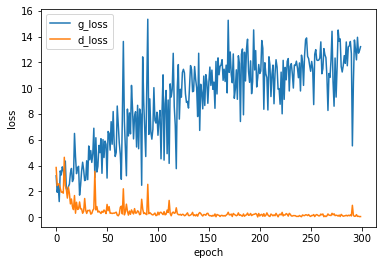

In [67]:
plt.plot(losses_g)
plt.plot(losses_d)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(['g_loss', 'd_loss'])

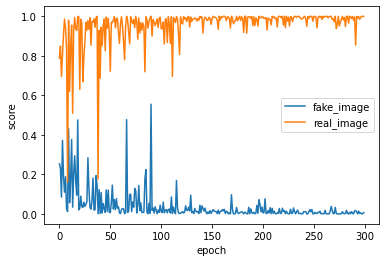

In [69]:
plt.plot(fake_scores)
plt.plot(real_scores)

plt.xlabel("epoch")
plt.ylabel("score")
plt.legend(['fake_image', 'real_image'])

In [ ]:
history = fit(epochs, lr)

  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [1/300], loss_g: 2.9714, loss_d: 3.2050, real_score: 0.8312, fake_score1: 0.2002, fake_score2: 0.1014
Saving generated-images-0001.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [2/300], loss_g: 3.6597, loss_d: 2.5545, real_score: 0.9113, fake_score1: 0.2622, fake_score2: 0.0854
Saving generated-images-0002.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [3/300], loss_g: 5.2773, loss_d: 2.9523, real_score: 0.8945, fake_score1: 0.4201, fake_score2: 0.0347
Saving generated-images-0003.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [4/300], loss_g: 3.0627, loss_d: 2.2371, real_score: 0.7129, fake_score1: 0.0657, fake_score2: 0.0760
Saving generated-images-0004.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [5/300], loss_g: 4.5625, loss_d: 2.2700, real_score: 0.7912, fake_score1: 0.2016, fake_score2: 0.0176
Saving generated-images-0005.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [6/300], loss_g: 3.6524, loss_d: 1.9408, real_score: 0.8359, fake_score1: 0.1156, fake_score2: 0.0395
Saving generated-images-0006.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [7/300], loss_g: 5.3868, loss_d: 2.1080, real_score: 0.9079, fake_score1: 0.2083, fake_score2: 0.0076
Saving generated-images-0007.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [8/300], loss_g: 4.8430, loss_d: 2.0990, real_score: 0.5387, fake_score1: 0.0021, fake_score2: 0.0168
Saving generated-images-0008.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [9/300], loss_g: 1.8138, loss_d: 2.0275, real_score: 0.4934, fake_score1: 0.0043, fake_score2: 0.2269
Saving generated-images-0009.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [10/300], loss_g: 3.5229, loss_d: 1.6146, real_score: 0.6538, fake_score1: 0.0240, fake_score2: 0.0471
Saving generated-images-0010.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [11/300], loss_g: 4.0292, loss_d: 1.0511, real_score: 0.9214, fake_score1: 0.1241, fake_score2: 0.0265
Saving generated-images-0011.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [12/300], loss_g: 5.2222, loss_d: 1.2723, real_score: 0.9453, fake_score1: 0.2137, fake_score2: 0.0118
Saving generated-images-0012.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [13/300], loss_g: 4.1220, loss_d: 0.9826, real_score: 0.9224, fake_score1: 0.1941, fake_score2: 0.0240
Saving generated-images-0013.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [14/300], loss_g: 4.5159, loss_d: 1.0317, real_score: 0.8560, fake_score1: 0.1298, fake_score2: 0.0199
Saving generated-images-0014.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [15/300], loss_g: 3.1958, loss_d: 1.1350, real_score: 0.9388, fake_score1: 0.1881, fake_score2: 0.0577
Saving generated-images-0015.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [16/300], loss_g: 4.8546, loss_d: 0.7126, real_score: 0.8853, fake_score1: 0.0551, fake_score2: 0.0143
Saving generated-images-0016.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [17/300], loss_g: 6.2759, loss_d: 0.8563, real_score: 0.9613, fake_score1: 0.2819, fake_score2: 0.0026
Saving generated-images-0017.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [18/300], loss_g: 5.8858, loss_d: 1.1232, real_score: 0.9242, fake_score1: 0.3452, fake_score2: 0.0046
Saving generated-images-0018.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [19/300], loss_g: 2.9857, loss_d: 0.8990, real_score: 0.6626, fake_score1: 0.0247, fake_score2: 0.1000
Saving generated-images-0019.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [20/300], loss_g: 6.6232, loss_d: 1.0891, real_score: 0.8942, fake_score1: 0.3161, fake_score2: 0.0021
Saving generated-images-0020.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [21/300], loss_g: 1.7676, loss_d: 0.9792, real_score: 0.6826, fake_score1: 0.1309, fake_score2: 0.2220
Saving generated-images-0021.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [22/300], loss_g: 6.0399, loss_d: 0.9046, real_score: 0.9563, fake_score1: 0.3668, fake_score2: 0.0038
Saving generated-images-0022.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [23/300], loss_g: 2.9365, loss_d: 0.8382, real_score: 0.8313, fake_score1: 0.0956, fake_score2: 0.0726
Saving generated-images-0023.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [24/300], loss_g: 4.4990, loss_d: 0.6929, real_score: 0.9300, fake_score1: 0.1868, fake_score2: 0.0192
Saving generated-images-0024.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [25/300], loss_g: 4.9374, loss_d: 0.3966, real_score: 0.9739, fake_score1: 0.0668, fake_score2: 0.0099
Saving generated-images-0025.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [26/300], loss_g: 5.6930, loss_d: 0.3940, real_score: 0.9472, fake_score1: 0.0191, fake_score2: 0.0059
Saving generated-images-0026.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [27/300], loss_g: 4.7863, loss_d: 0.3592, real_score: 0.9871, fake_score1: 0.0522, fake_score2: 0.0125
Saving generated-images-0027.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [28/300], loss_g: 5.4192, loss_d: 0.2603, real_score: 0.9383, fake_score1: 0.0363, fake_score2: 0.0061
Saving generated-images-0028.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [29/300], loss_g: 3.9065, loss_d: 0.6076, real_score: 0.6995, fake_score1: 0.0154, fake_score2: 0.0363
Saving generated-images-0029.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [30/300], loss_g: 4.1202, loss_d: 0.3431, real_score: 0.9839, fake_score1: 0.0922, fake_score2: 0.0234
Saving generated-images-0030.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [31/300], loss_g: 4.7448, loss_d: 0.4000, real_score: 0.9853, fake_score1: 0.1299, fake_score2: 0.0133
Saving generated-images-0031.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [32/300], loss_g: 4.3832, loss_d: 0.4890, real_score: 0.9687, fake_score1: 0.0878, fake_score2: 0.0160
Saving generated-images-0032.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [33/300], loss_g: 1.3230, loss_d: 0.6225, real_score: 0.7757, fake_score1: 0.0545, fake_score2: 0.3607
Saving generated-images-0033.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [34/300], loss_g: 5.2665, loss_d: 0.5240, real_score: 0.9145, fake_score1: 0.1931, fake_score2: 0.0072
Saving generated-images-0034.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [35/300], loss_g: 7.2475, loss_d: 0.5643, real_score: 0.9529, fake_score1: 0.2604, fake_score2: 0.0014
Saving generated-images-0035.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [36/300], loss_g: 12.5255, loss_d: 1.7143, real_score: 0.9942, fake_score1: 0.6592, fake_score2: 0.0000
Saving generated-images-0036.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [37/300], loss_g: 3.9486, loss_d: 0.3574, real_score: 0.9298, fake_score1: 0.1021, fake_score2: 0.0286
Saving generated-images-0037.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [38/300], loss_g: 4.3272, loss_d: 0.2839, real_score: 0.9286, fake_score1: 0.0424, fake_score2: 0.0210
Saving generated-images-0038.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [39/300], loss_g: 4.3790, loss_d: 0.5335, real_score: 0.8381, fake_score1: 0.1466, fake_score2: 0.0181
Saving generated-images-0039.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [40/300], loss_g: 3.9842, loss_d: 0.3313, real_score: 0.9101, fake_score1: 0.0806, fake_score2: 0.0260
Saving generated-images-0040.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [41/300], loss_g: 3.1926, loss_d: 0.4854, real_score: 0.9188, fake_score1: 0.0292, fake_score2: 0.0971
Saving generated-images-0041.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [42/300], loss_g: 2.0646, loss_d: 0.5222, real_score: 0.7204, fake_score1: 0.0318, fake_score2: 0.2016
Saving generated-images-0042.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [43/300], loss_g: 3.7792, loss_d: 0.2682, real_score: 0.9926, fake_score1: 0.0647, fake_score2: 0.0362
Saving generated-images-0043.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [44/300], loss_g: 1.1170, loss_d: 0.8186, real_score: 0.5988, fake_score1: 0.0645, fake_score2: 0.3966
Saving generated-images-0044.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [45/300], loss_g: 4.5068, loss_d: 0.2332, real_score: 0.9688, fake_score1: 0.0374, fake_score2: 0.0161
Saving generated-images-0045.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [46/300], loss_g: 5.2302, loss_d: 0.3243, real_score: 0.9676, fake_score1: 0.0454, fake_score2: 0.0095
Saving generated-images-0046.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [47/300], loss_g: 5.4126, loss_d: 0.3827, real_score: 0.9503, fake_score1: 0.0482, fake_score2: 0.0080
Saving generated-images-0047.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [48/300], loss_g: 4.5094, loss_d: 0.3510, real_score: 0.8925, fake_score1: 0.1101, fake_score2: 0.0176
Saving generated-images-0048.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [49/300], loss_g: 4.1086, loss_d: 0.2777, real_score: 0.9350, fake_score1: 0.0200, fake_score2: 0.0239
Saving generated-images-0049.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [50/300], loss_g: 4.8273, loss_d: 0.4963, real_score: 0.8927, fake_score1: 0.0510, fake_score2: 0.0143
Saving generated-images-0050.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [51/300], loss_g: 9.3272, loss_d: 2.1468, real_score: 0.9995, fake_score1: 0.7880, fake_score2: 0.0002
Saving generated-images-0051.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [52/300], loss_g: 4.1951, loss_d: 0.2735, real_score: 0.9879, fake_score1: 0.0647, fake_score2: 0.0248
Saving generated-images-0052.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [53/300], loss_g: 2.6359, loss_d: 0.4633, real_score: 0.8039, fake_score1: 0.0439, fake_score2: 0.1049
Saving generated-images-0053.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [54/300], loss_g: 3.4357, loss_d: 0.5083, real_score: 0.9310, fake_score1: 0.0825, fake_score2: 0.0492
Saving generated-images-0054.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [55/300], loss_g: 0.2304, loss_d: 1.3104, real_score: 0.4159, fake_score1: 0.0184, fake_score2: 0.8352
Saving generated-images-0055.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [56/300], loss_g: 2.7397, loss_d: 0.5844, real_score: 0.7933, fake_score1: 0.1306, fake_score2: 0.0803
Saving generated-images-0056.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [57/300], loss_g: 4.3350, loss_d: 0.4373, real_score: 0.8769, fake_score1: 0.1788, fake_score2: 0.0227
Saving generated-images-0057.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [58/300], loss_g: 4.5527, loss_d: 0.4044, real_score: 0.9475, fake_score1: 0.1810, fake_score2: 0.0151
Saving generated-images-0058.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [59/300], loss_g: 3.5487, loss_d: 1.1223, real_score: 0.4363, fake_score1: 0.0007, fake_score2: 0.0594
Saving generated-images-0059.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [60/300], loss_g: 4.9162, loss_d: 0.1918, real_score: 0.9362, fake_score1: 0.0379, fake_score2: 0.0127
Saving generated-images-0060.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [61/300], loss_g: 5.3303, loss_d: 0.2528, real_score: 0.9336, fake_score1: 0.0143, fake_score2: 0.0080
Saving generated-images-0061.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [62/300], loss_g: 2.7037, loss_d: 0.3977, real_score: 0.8685, fake_score1: 0.0638, fake_score2: 0.1010
Saving generated-images-0062.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [63/300], loss_g: 1.6034, loss_d: 0.6918, real_score: 0.7205, fake_score1: 0.0602, fake_score2: 0.2764
Saving generated-images-0063.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [64/300], loss_g: 4.3580, loss_d: 0.3196, real_score: 0.9836, fake_score1: 0.1408, fake_score2: 0.0215
Saving generated-images-0064.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [65/300], loss_g: 3.2649, loss_d: 0.5004, real_score: 0.8449, fake_score1: 0.1485, fake_score2: 0.0585
Saving generated-images-0065.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [66/300], loss_g: 4.3526, loss_d: 0.2516, real_score: 0.9729, fake_score1: 0.0242, fake_score2: 0.0212
Saving generated-images-0066.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [67/300], loss_g: 5.3164, loss_d: 0.4574, real_score: 0.9984, fake_score1: 0.2472, fake_score2: 0.0070
Saving generated-images-0067.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [68/300], loss_g: 3.9053, loss_d: 0.8324, real_score: 0.8182, fake_score1: 0.0128, fake_score2: 0.0811
Saving generated-images-0068.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [69/300], loss_g: 4.5169, loss_d: 0.1901, real_score: 0.9725, fake_score1: 0.0264, fake_score2: 0.0194
Saving generated-images-0069.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [70/300], loss_g: 3.2164, loss_d: 0.1652, real_score: 0.9767, fake_score1: 0.0381, fake_score2: 0.0662
Saving generated-images-0070.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [71/300], loss_g: 1.2174, loss_d: 1.1818, real_score: 0.4743, fake_score1: 0.0457, fake_score2: 0.4061
Saving generated-images-0071.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [72/300], loss_g: 2.6433, loss_d: 0.4103, real_score: 0.7859, fake_score1: 0.0485, fake_score2: 0.1069
Saving generated-images-0072.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [73/300], loss_g: 4.1096, loss_d: 0.5194, real_score: 0.9858, fake_score1: 0.2259, fake_score2: 0.0324
Saving generated-images-0073.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [74/300], loss_g: 7.6470, loss_d: 0.2300, real_score: 0.9413, fake_score1: 0.0135, fake_score2: 0.0013
Saving generated-images-0074.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [75/300], loss_g: 4.3285, loss_d: 0.1135, real_score: 0.9871, fake_score1: 0.0390, fake_score2: 0.0223
Saving generated-images-0075.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [76/300], loss_g: 2.3424, loss_d: 0.5464, real_score: 0.7460, fake_score1: 0.0674, fake_score2: 0.1528
Saving generated-images-0076.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [77/300], loss_g: 3.8459, loss_d: 1.1437, real_score: 0.4961, fake_score1: 0.0021, fake_score2: 0.0445
Saving generated-images-0077.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [78/300], loss_g: 3.6656, loss_d: 0.6897, real_score: 0.8103, fake_score1: 0.1988, fake_score2: 0.0445
Saving generated-images-0078.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [79/300], loss_g: 4.0879, loss_d: 0.3924, real_score: 0.8961, fake_score1: 0.0288, fake_score2: 0.0363
Saving generated-images-0079.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [80/300], loss_g: 5.5489, loss_d: 0.2341, real_score: 0.9894, fake_score1: 0.0557, fake_score2: 0.0062
Saving generated-images-0080.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [81/300], loss_g: 0.8075, loss_d: 1.0340, real_score: 0.5260, fake_score1: 0.0398, fake_score2: 0.5701
Saving generated-images-0081.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [82/300], loss_g: 2.2622, loss_d: 0.6745, real_score: 0.7561, fake_score1: 0.1019, fake_score2: 0.1430
Saving generated-images-0082.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [83/300], loss_g: 3.5272, loss_d: 0.2387, real_score: 0.9168, fake_score1: 0.0571, fake_score2: 0.0421
Saving generated-images-0083.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [84/300], loss_g: 5.1507, loss_d: 0.2347, real_score: 0.9344, fake_score1: 0.0140, fake_score2: 0.0111
Saving generated-images-0084.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [85/300], loss_g: 3.8183, loss_d: 0.3638, real_score: 0.8907, fake_score1: 0.0409, fake_score2: 0.0382
Saving generated-images-0085.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [86/300], loss_g: 3.9120, loss_d: 0.2260, real_score: 0.9419, fake_score1: 0.0291, fake_score2: 0.0316
Saving generated-images-0086.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [87/300], loss_g: 5.0278, loss_d: 0.4439, real_score: 0.8923, fake_score1: 0.0370, fake_score2: 0.0127
Saving generated-images-0087.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [88/300], loss_g: 5.3326, loss_d: 0.2506, real_score: 0.9201, fake_score1: 0.0074, fake_score2: 0.0158
Saving generated-images-0088.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [89/300], loss_g: 4.3922, loss_d: 0.2132, real_score: 0.9932, fake_score1: 0.0748, fake_score2: 0.0203
Saving generated-images-0089.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [90/300], loss_g: 11.0262, loss_d: 4.7312, real_score: 0.9997, fake_score1: 0.9635, fake_score2: 0.0003
Saving generated-images-0090.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [91/300], loss_g: 5.0049, loss_d: 0.4035, real_score: 0.9768, fake_score1: 0.1043, fake_score2: 0.0103
Saving generated-images-0091.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [92/300], loss_g: 5.3344, loss_d: 0.1864, real_score: 0.9857, fake_score1: 0.0696, fake_score2: 0.0115
Saving generated-images-0092.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [93/300], loss_g: 1.9989, loss_d: 0.5363, real_score: 0.6893, fake_score1: 0.0079, fake_score2: 0.2024
Saving generated-images-0093.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [94/300], loss_g: 7.6131, loss_d: 0.8416, real_score: 0.9986, fake_score1: 0.4152, fake_score2: 0.0009
Saving generated-images-0094.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [95/300], loss_g: 6.0760, loss_d: 0.3136, real_score: 0.9695, fake_score1: 0.1298, fake_score2: 0.0046
Saving generated-images-0095.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [96/300], loss_g: 1.6327, loss_d: 7.2044, real_score: 0.0186, fake_score1: 0.0000, fake_score2: 0.4517
Saving generated-images-0096.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [97/300], loss_g: 6.5389, loss_d: 0.1935, real_score: 0.9839, fake_score1: 0.0071, fake_score2: 0.0043
Saving generated-images-0097.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [98/300], loss_g: 4.0135, loss_d: 0.1802, real_score: 0.9449, fake_score1: 0.0575, fake_score2: 0.0313
Saving generated-images-0098.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [99/300], loss_g: 4.8379, loss_d: 0.1546, real_score: 0.9576, fake_score1: 0.0115, fake_score2: 0.0126
Saving generated-images-0099.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [100/300], loss_g: 3.4639, loss_d: 0.4732, real_score: 0.8234, fake_score1: 0.0315, fake_score2: 0.0686
Saving generated-images-0100.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [101/300], loss_g: 5.9861, loss_d: 0.7731, real_score: 0.8841, fake_score1: 0.3513, fake_score2: 0.0045
Saving generated-images-0101.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [102/300], loss_g: 6.5995, loss_d: 0.2558, real_score: 0.9798, fake_score1: 0.1513, fake_score2: 0.0034
Saving generated-images-0102.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [103/300], loss_g: 9.6603, loss_d: 0.4820, real_score: 0.9913, fake_score1: 0.2852, fake_score2: 0.0001
Saving generated-images-0103.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [104/300], loss_g: 5.0616, loss_d: 0.2129, real_score: 0.9933, fake_score1: 0.0662, fake_score2: 0.0096
Saving generated-images-0104.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [105/300], loss_g: 4.6571, loss_d: 0.2756, real_score: 0.9918, fake_score1: 0.0816, fake_score2: 0.0159
Saving generated-images-0105.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [106/300], loss_g: 4.7110, loss_d: 0.4077, real_score: 0.8585, fake_score1: 0.0132, fake_score2: 0.0200
Saving generated-images-0106.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [107/300], loss_g: 1.3610, loss_d: 0.5025, real_score: 0.6928, fake_score1: 0.0200, fake_score2: 0.3788
Saving generated-images-0107.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [108/300], loss_g: 4.4658, loss_d: 0.1159, real_score: 0.9776, fake_score1: 0.0314, fake_score2: 0.0203
Saving generated-images-0108.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [109/300], loss_g: 5.8712, loss_d: 0.2421, real_score: 0.9518, fake_score1: 0.0463, fake_score2: 0.0062
Saving generated-images-0109.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [110/300], loss_g: 1.3401, loss_d: 0.6707, real_score: 0.6545, fake_score1: 0.0191, fake_score2: 0.3701
Saving generated-images-0110.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [111/300], loss_g: 4.0975, loss_d: 0.4915, real_score: 0.9985, fake_score1: 0.1990, fake_score2: 0.0243
Saving generated-images-0111.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [112/300], loss_g: 1.9278, loss_d: 1.0151, real_score: 0.5063, fake_score1: 0.0027, fake_score2: 0.2720
Saving generated-images-0112.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [113/300], loss_g: 1.4067, loss_d: 0.8346, real_score: 0.6048, fake_score1: 0.0597, fake_score2: 0.3521
Saving generated-images-0113.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [114/300], loss_g: 5.3839, loss_d: 0.2138, real_score: 0.8799, fake_score1: 0.0236, fake_score2: 0.0096
Saving generated-images-0114.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [115/300], loss_g: 5.8001, loss_d: 0.3797, real_score: 0.9996, fake_score1: 0.1934, fake_score2: 0.0053
Saving generated-images-0115.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [116/300], loss_g: 3.9286, loss_d: 0.2490, real_score: 0.9275, fake_score1: 0.0636, fake_score2: 0.0295
Saving generated-images-0116.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [117/300], loss_g: 5.5088, loss_d: 0.2418, real_score: 0.9991, fake_score1: 0.1165, fake_score2: 0.0068
Saving generated-images-0117.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [118/300], loss_g: 5.3171, loss_d: 0.2631, real_score: 0.9620, fake_score1: 0.0270, fake_score2: 0.0105
Saving generated-images-0118.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [119/300], loss_g: 14.1880, loss_d: 1.8256, real_score: 0.9890, fake_score1: 0.7248, fake_score2: 0.0000
Saving generated-images-0119.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [120/300], loss_g: 4.8377, loss_d: 0.1341, real_score: 0.9278, fake_score1: 0.0133, fake_score2: 0.0166
Saving generated-images-0120.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [121/300], loss_g: 3.1495, loss_d: 1.2975, real_score: 0.4436, fake_score1: 0.0018, fake_score2: 0.0916
Saving generated-images-0121.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [122/300], loss_g: 1.2319, loss_d: 1.0361, real_score: 0.4954, fake_score1: 0.0314, fake_score2: 0.3992
Saving generated-images-0122.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [123/300], loss_g: 5.9685, loss_d: 0.4447, real_score: 0.9931, fake_score1: 0.2651, fake_score2: 0.0057
Saving generated-images-0123.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [124/300], loss_g: 5.2627, loss_d: 0.0496, real_score: 0.9964, fake_score1: 0.0165, fake_score2: 0.0123
Saving generated-images-0124.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [125/300], loss_g: 5.5216, loss_d: 0.8196, real_score: 0.9848, fake_score1: 0.2884, fake_score2: 0.0085
Saving generated-images-0125.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [126/300], loss_g: 5.5535, loss_d: 0.1398, real_score: 0.9660, fake_score1: 0.0155, fake_score2: 0.0077
Saving generated-images-0126.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [127/300], loss_g: 6.2859, loss_d: 0.3707, real_score: 0.9998, fake_score1: 0.2217, fake_score2: 0.0030
Saving generated-images-0127.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [128/300], loss_g: 5.5574, loss_d: 0.1062, real_score: 0.9926, fake_score1: 0.0334, fake_score2: 0.0097
Saving generated-images-0128.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [129/300], loss_g: 0.3779, loss_d: 1.0802, real_score: 0.5106, fake_score1: 0.0283, fake_score2: 0.7600
Saving generated-images-0129.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [130/300], loss_g: 5.1967, loss_d: 0.1081, real_score: 0.9978, fake_score1: 0.0213, fake_score2: 0.0103
Saving generated-images-0130.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [131/300], loss_g: 4.0041, loss_d: 0.2393, real_score: 0.9696, fake_score1: 0.0705, fake_score2: 0.0311
Saving generated-images-0131.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [132/300], loss_g: 3.2680, loss_d: 0.4035, real_score: 0.7608, fake_score1: 0.0107, fake_score2: 0.0625
Saving generated-images-0132.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [133/300], loss_g: 4.9034, loss_d: 0.2215, real_score: 0.9988, fake_score1: 0.0187, fake_score2: 0.0138
Saving generated-images-0133.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [134/300], loss_g: 5.2006, loss_d: 0.0972, real_score: 0.9944, fake_score1: 0.0192, fake_score2: 0.0109
Saving generated-images-0134.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [135/300], loss_g: 4.0963, loss_d: 0.4728, real_score: 0.9958, fake_score1: 0.1048, fake_score2: 0.0259
Saving generated-images-0135.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [136/300], loss_g: 6.2755, loss_d: 0.1652, real_score: 0.9751, fake_score1: 0.0080, fake_score2: 0.0076
Saving generated-images-0136.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [137/300], loss_g: 4.9146, loss_d: 0.1524, real_score: 0.9777, fake_score1: 0.0817, fake_score2: 0.0131
Saving generated-images-0137.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [138/300], loss_g: 6.2511, loss_d: 0.3173, real_score: 0.9759, fake_score1: 0.1331, fake_score2: 0.0031
Saving generated-images-0138.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [139/300], loss_g: 6.1411, loss_d: 0.2625, real_score: 0.9739, fake_score1: 0.0630, fake_score2: 0.0036
Saving generated-images-0139.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [140/300], loss_g: 6.1480, loss_d: 0.1688, real_score: 0.9992, fake_score1: 0.0164, fake_score2: 0.0040
Saving generated-images-0140.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [141/300], loss_g: 5.2843, loss_d: 0.4276, real_score: 0.9944, fake_score1: 0.1256, fake_score2: 0.0082
Saving generated-images-0141.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [142/300], loss_g: 2.0309, loss_d: 0.3614, real_score: 0.7714, fake_score1: 0.0144, fake_score2: 0.2137
Saving generated-images-0142.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [143/300], loss_g: 5.7270, loss_d: 0.2159, real_score: 0.8915, fake_score1: 0.0055, fake_score2: 0.0126
Saving generated-images-0143.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [144/300], loss_g: 5.7046, loss_d: 0.0864, real_score: 0.9954, fake_score1: 0.0154, fake_score2: 0.0057
Saving generated-images-0144.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [145/300], loss_g: 6.4266, loss_d: 0.3399, real_score: 0.9704, fake_score1: 0.0836, fake_score2: 0.0052
Saving generated-images-0145.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [146/300], loss_g: 4.5252, loss_d: 0.1307, real_score: 0.9788, fake_score1: 0.0527, fake_score2: 0.0193
Saving generated-images-0146.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [147/300], loss_g: 0.0502, loss_d: 2.1487, real_score: 0.2415, fake_score1: 0.0194, fake_score2: 0.9674
Saving generated-images-0147.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [148/300], loss_g: 2.9252, loss_d: 0.2943, real_score: 0.8253, fake_score1: 0.0252, fake_score2: 0.0975
Saving generated-images-0148.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [149/300], loss_g: 4.9496, loss_d: 0.1103, real_score: 0.9967, fake_score1: 0.0398, fake_score2: 0.0134
Saving generated-images-0149.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [150/300], loss_g: 3.2251, loss_d: 0.2912, real_score: 0.8160, fake_score1: 0.0108, fake_score2: 0.0780
Saving generated-images-0150.png


  0%|          | 0/141 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
history = fit(epochs, lr)

  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [1/300], loss_g: 5.2201, loss_d: 0.4484, real_score: 0.9128, fake_score: 0.2712
Saving generated-images-0001.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [2/300], loss_g: 9.7153, loss_d: 0.1475, real_score: 0.8944, fake_score: 0.0001
Saving generated-images-0002.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [3/300], loss_g: 1.9997, loss_d: 0.4637, real_score: 0.7904, fake_score: 0.1718
Saving generated-images-0003.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [4/300], loss_g: 2.6564, loss_d: 0.5815, real_score: 0.6361, fake_score: 0.0657
Saving generated-images-0004.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [5/300], loss_g: 1.3577, loss_d: 1.2996, real_score: 0.4214, fake_score: 0.1102
Saving generated-images-0005.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [6/300], loss_g: 2.2438, loss_d: 1.2267, real_score: 0.3557, fake_score: 0.0209
Saving generated-images-0006.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [7/300], loss_g: 5.6926, loss_d: 0.4680, real_score: 0.9477, fake_score: 0.3081
Saving generated-images-0007.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [8/300], loss_g: 7.2376, loss_d: 0.6261, real_score: 0.9584, fake_score: 0.3819
Saving generated-images-0008.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [9/300], loss_g: 3.3911, loss_d: 0.3845, real_score: 0.8937, fake_score: 0.2125
Saving generated-images-0009.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [10/300], loss_g: 2.8853, loss_d: 1.1189, real_score: 0.4034, fake_score: 0.0214
Saving generated-images-0010.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [11/300], loss_g: 4.2427, loss_d: 0.5988, real_score: 0.8232, fake_score: 0.2996
Saving generated-images-0011.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [12/300], loss_g: 6.8189, loss_d: 0.1027, real_score: 0.9213, fake_score: 0.0154
Saving generated-images-0012.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [13/300], loss_g: 3.2058, loss_d: 0.2451, real_score: 0.9151, fake_score: 0.1292
Saving generated-images-0013.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [14/300], loss_g: 2.0082, loss_d: 0.5816, real_score: 0.6442, fake_score: 0.0973
Saving generated-images-0014.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [15/300], loss_g: 1.8383, loss_d: 0.6129, real_score: 0.6621, fake_score: 0.1139
Saving generated-images-0015.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [16/300], loss_g: 4.5336, loss_d: 0.3866, real_score: 0.9054, fake_score: 0.2230
Saving generated-images-0016.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [17/300], loss_g: 0.7947, loss_d: 0.6861, real_score: 0.5938, fake_score: 0.0892
Saving generated-images-0017.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [18/300], loss_g: 5.2185, loss_d: 0.2239, real_score: 0.8778, fake_score: 0.0761
Saving generated-images-0018.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [19/300], loss_g: 4.5996, loss_d: 0.2144, real_score: 0.9211, fake_score: 0.1173
Saving generated-images-0019.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [20/300], loss_g: 2.3336, loss_d: 0.3259, real_score: 0.9372, fake_score: 0.2022
Saving generated-images-0020.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [21/300], loss_g: 4.9631, loss_d: 0.2918, real_score: 0.9612, fake_score: 0.1962
Saving generated-images-0021.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [22/300], loss_g: 3.5806, loss_d: 0.1732, real_score: 0.9245, fake_score: 0.0834
Saving generated-images-0022.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [23/300], loss_g: 3.5742, loss_d: 0.7454, real_score: 0.9282, fake_score: 0.4543
Saving generated-images-0023.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [24/300], loss_g: 0.3757, loss_d: 1.5886, real_score: 0.2595, fake_score: 0.0058
Saving generated-images-0024.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [25/300], loss_g: 3.5567, loss_d: 0.4531, real_score: 0.6958, fake_score: 0.0365
Saving generated-images-0025.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [26/300], loss_g: 3.6361, loss_d: 0.3233, real_score: 0.7706, fake_score: 0.0391
Saving generated-images-0026.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [27/300], loss_g: 2.4176, loss_d: 0.3365, real_score: 0.9405, fake_score: 0.2153
Saving generated-images-0027.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [28/300], loss_g: 3.7566, loss_d: 0.2688, real_score: 0.8724, fake_score: 0.1100
Saving generated-images-0028.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [29/300], loss_g: 0.2233, loss_d: 1.1264, real_score: 0.4280, fake_score: 0.0360
Saving generated-images-0029.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [30/300], loss_g: 2.9838, loss_d: 0.3907, real_score: 0.9500, fake_score: 0.2526
Saving generated-images-0030.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [31/300], loss_g: 1.9911, loss_d: 0.4758, real_score: 0.7102, fake_score: 0.0681
Saving generated-images-0031.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [32/300], loss_g: 1.3204, loss_d: 0.7762, real_score: 0.5094, fake_score: 0.0340
Saving generated-images-0032.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [33/300], loss_g: 1.8967, loss_d: 0.2521, real_score: 0.8669, fake_score: 0.0849
Saving generated-images-0033.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [34/300], loss_g: 2.6165, loss_d: 0.1814, real_score: 0.9615, fake_score: 0.1212
Saving generated-images-0034.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [35/300], loss_g: 4.9115, loss_d: 0.0668, real_score: 0.9868, fake_score: 0.0503
Saving generated-images-0035.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [36/300], loss_g: 0.9595, loss_d: 0.5363, real_score: 0.6833, fake_score: 0.0800
Saving generated-images-0036.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [37/300], loss_g: 1.5380, loss_d: 0.4757, real_score: 0.7046, fake_score: 0.0567
Saving generated-images-0037.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [38/300], loss_g: 7.6248, loss_d: 0.7351, real_score: 0.9486, fake_score: 0.4537
Saving generated-images-0038.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [39/300], loss_g: 6.0469, loss_d: 1.0996, real_score: 0.9927, fake_score: 0.5634
Saving generated-images-0039.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [40/300], loss_g: 5.6443, loss_d: 0.2869, real_score: 0.7850, fake_score: 0.0160
Saving generated-images-0040.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [41/300], loss_g: 3.8869, loss_d: 0.2156, real_score: 0.8701, fake_score: 0.0627
Saving generated-images-0041.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [42/300], loss_g: 6.9790, loss_d: 0.9832, real_score: 0.9227, fake_score: 0.4951
Saving generated-images-0042.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [43/300], loss_g: 2.9469, loss_d: 0.3163, real_score: 0.7883, fake_score: 0.0587
Saving generated-images-0043.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [44/300], loss_g: 6.2024, loss_d: 0.4819, real_score: 0.8633, fake_score: 0.2509
Saving generated-images-0044.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [45/300], loss_g: 2.9537, loss_d: 0.0996, real_score: 0.9470, fake_score: 0.0421
Saving generated-images-0045.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [46/300], loss_g: 0.9038, loss_d: 0.4491, real_score: 0.6848, fake_score: 0.0375
Saving generated-images-0046.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [47/300], loss_g: 0.3118, loss_d: 1.4356, real_score: 0.3721, fake_score: 0.1642
Saving generated-images-0047.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [48/300], loss_g: 4.8191, loss_d: 0.2191, real_score: 0.8381, fake_score: 0.0313
Saving generated-images-0048.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [49/300], loss_g: 0.2835, loss_d: 1.1292, real_score: 0.3952, fake_score: 0.0164
Saving generated-images-0049.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [50/300], loss_g: 3.5823, loss_d: 0.7616, real_score: 0.8415, fake_score: 0.3714
Saving generated-images-0050.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [51/300], loss_g: 2.9252, loss_d: 0.3374, real_score: 0.7737, fake_score: 0.0421
Saving generated-images-0051.png


  0%|          | 0/140 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

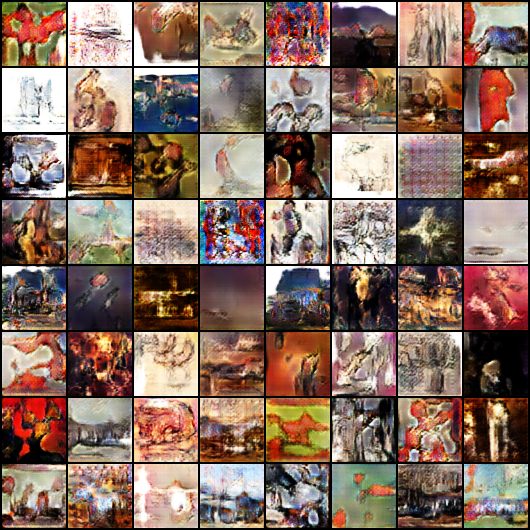

In [ ]:
Image('0318_generated_plots/generated-images-0050.png')

In [ ]:
loss_g, losses_d, real_scores, fake_scores = history